## Proactive Machine Predictive Maintenance using Advanced Machine Learning Algorithms

The primary goal of the project is to showcase the effectiveness and efficiency of implementing tools such as Pipeline transformers and Grid Search for training machine learning models. By applying these tools, the project aims to optimize the model creation process, enabling simultaneous management of various data processing stages and the search for optimal model hyperparameters. As a result, the project can provide valuable insights into effective practices in the field of predicting machine failures using advanced machine learning techniques.

Dataset comes from following sources and concerned predictive maintenace:

https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset

The dataset consists of 10 000 data points stored as rows with 14 features in columns:
- UID: unique identifier ranging from 1 to 10000.
- Product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number.
- Air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.
- Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- Rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise.
- Torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
- Target : Failure or Not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
# pipeline construction
from sklearn.pipeline import Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
# models validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
# models trainng
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report   
import warnings
warnings.filterwarnings('ignore')
sns.set()

### Loading data

In [2]:
df = pd.read_csv('Data_UCI/ai4i2020.csv')
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


### Data modeling / Feature engineering

In [3]:
# function used to describe data:
def info_data(data):
    return pd.DataFrame({
            'no.unique': (data.nunique()),
            'value_type': (data.dtypes),
            'mean': (data.mean(numeric_only=True).round(1)),
            'std': (data.std(numeric_only=True).round(1)),
            'min': (data.min(numeric_only=True)),
            'median': (data.median(numeric_only=True)),
            'max': (data.max(numeric_only=True)),
            'mode': (data.mode().iloc[0]),
            'is.NaN': (data.isna().sum())   
            })

#### Categorical values

In [4]:
"""
The dataset consists of categorical data:
- contains a "Product ID" that is unique for all samples, which is not significant 
for the creation of the ML model and will be removed,
- "Type" (type of tools) conatins 3 categories and will be encoded in the next step.
"""
df_category = df.select_dtypes(exclude=np.number)
info_data(df_category)

,no.unique,value_type,mean,std,min,median,max,mode,is.NaN
Product ID,10000,object,NaN,NaN,NaN,NaN,NaN,H29424,0
Type,3,object,NaN,NaN,NaN,NaN,NaN,L,0


- No missing values in the data set
- No duplicated data

In [5]:
df['Type'].value_counts(normalize=True)

Type
L    0.6000
M    0.2997
H    0.1003
Name: proportion, dtype: float64

In [6]:
df.groupby('Type')['Machine failure'].mean().sort_values(ascending=False)

Type
L    0.039167
M    0.027694
H    0.020937
Name: Machine failure, dtype: float64

In [7]:
pd.crosstab(df['Type'], df['Machine failure'], normalize=True)

Machine failure,0,1
Type,,
H,0.0982,0.0021
L,0.5765,0.0235
M,0.2914,0.0083


#### Numerical values

In [8]:
"""
# The dataset consists of numerical data:
- "UDI" corespond with index, so it will be removed in the next step,
- first part of the numerical data is significant and will be processed in the following steps,
- second part of data include target "Machine failure" and the subsequent columns 
describing failure types.
"""
df_numeric = df.select_dtypes(include=np.number)
info_data(df_numeric)

,no.unique,value_type,mean,std,min,median,max,mode,is.NaN
UDI,10000,int64,5000.5,2886.9,1.0,5000.5,10000.0,1.0,0
Air temperature [K],93,float64,300.0,2.0,295.3,300.1,304.5,300.7,0
Process temperature [K],82,float64,310.0,1.5,305.7,310.1,313.8,310.6,0
Rotational speed [rpm],941,int64,1538.8,179.3,1168.0,1503.0,2886.0,1452.0,0
Torque [Nm],577,float64,40.0,10.0,3.8,40.1,76.6,40.2,0
Tool wear [min],246,int64,108.0,63.7,0.0,108.0,253.0,0.0,0
Machine failure,2,int64,0.0,0.2,0.0,0.0,1.0,0.0,0
TWF,2,int64,0.0,0.1,0.0,0.0,1.0,0.0,0
HDF,2,int64,0.0,0.1,0.0,0.0,1.0,0.0,0
PWF,2,int64,0.0,0.1,0.0,0.0,1.0,0.0,0


Machine failure types are described in the pie chart below

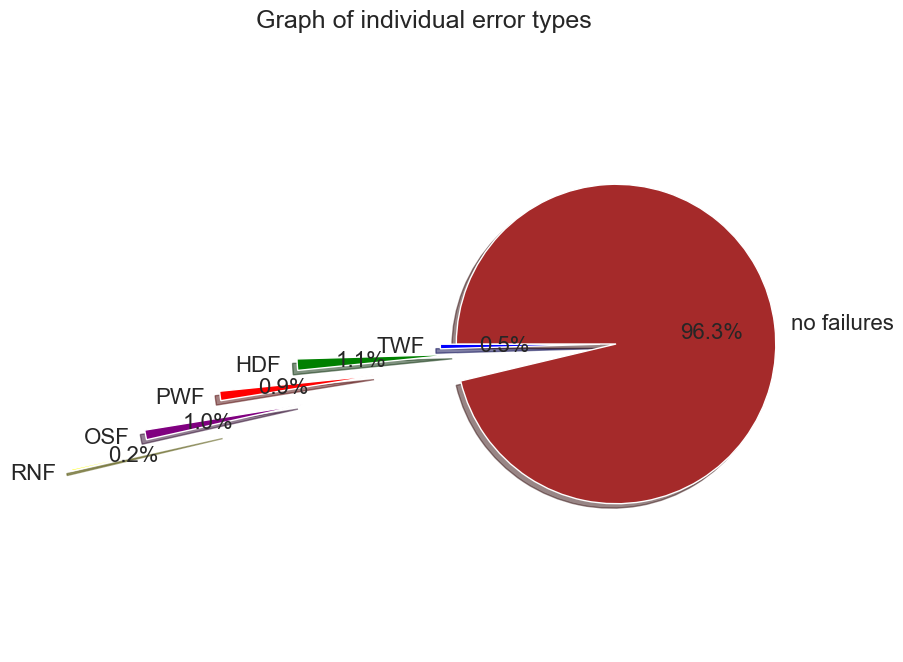

In [9]:
plt.figure(figsize=(10, 8))
labels = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'no failures']
sizes = [ # Percentage of each category:
    df['TWF'].value_counts(normalize=True)[1],
    df['HDF'].value_counts(normalize=True)[1],
    df['PWF'].value_counts(normalize=True)[1], 
    df['OSF'].value_counts(normalize=True)[1],
    df['RNF'].value_counts(normalize=True)[1],
    df['Machine failure'].value_counts(normalize=True)[0]]
colors = ['blue', 'green', 'red', 'purple', 'yellow', 'brown'] 
explode = (0.1, 1, 1.5, 2, 2.5, 0)
patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, 
                            colors=colors, autopct='%1.1f%%', shadow=True, startangle=180)
for text in texts + autotexts:
    text.set_fontsize(16)
plt.title('Graph of individual error types', fontsize=18)
plt.axis('equal')
plt.show()

Machine errors occur in less than 4% of cases, so the presented case shows the problem of unbalanced classes, so the creation of the ML model will take this problem into account.

### Missing values

- There are no missing values in the data presented.
- Similarly there are no duplicated data.

In [10]:
# check for duplicates in the data:
df.duplicated(keep=False).sum()

0

### Data transformation for numerical functions

##### Changing column names 
- to avoid errors in some ML algorithms, e.g. XGBClassifier

In [11]:
df.head(0)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF


In [12]:
class RemoveCharNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__( self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        def remove_char_from_columns(text):
            text = re.sub(r'\[.*?\]', '', text)
            return text.strip()
        X.columns = [remove_char_from_columns(col) for col in X.columns]
        return X

In [13]:
steps = [
    ('remove_char_col', RemoveCharNamesTransformer())
]
pipeline_num = Pipeline(steps=steps)
df_num_transf = pipeline_num.fit_transform(df)
df_num_transf.head(0)

,UDI,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF


In [14]:
class SelectColumnsByTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, type_to_select):
        self.type_to_select = type_to_select
    
    # even if nothing to fit, this method must return self
    def fit(self, X, y = None ):
        return self 
    
    def transform(self, X, y = None ):
        if self.type_to_select == 'numeric':
            return X.select_dtypes(include=np.number)
        elif self.type_to_select == 'object':
            return X.select_dtypes(exclude=np.number)
        else:
            raise Exception('Available types are: numeric, object')

In [15]:
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='numeric'))
]
pipeline_num = Pipeline(steps=steps)
df_num_transf = pipeline_num.fit_transform(df)
df_num_transf.head(3)

,UDI,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


##### Columns removal
- columns omitted due to lack of significant information: 'UDI', 'Product ID'

In [16]:
class RemoveColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, columns_to_remove: list):
        self.columns_to_remove = columns_to_remove
    # even if nothing to fit, this method must return self
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        return X.drop(self.columns_to_remove, axis=1)

In [17]:
columns_to_remove = ['UDI']
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='numeric')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove))
]
pipeline_num = Pipeline(steps=steps)
df_num_transf = pipeline_num.fit_transform(df)
df_num_transf.head(3)

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


#### Checking if all 'Machine failure' information correspond with failure type

In [18]:
failure_general = ['Machine failure']
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
machine_failure_true = df[failure_general+failure_types].loc[(df[failure_general] == 1).all(axis=1)]
machine_failure_true.loc[(df[failure_types] == 0).all(axis=1)].sum()

Machine failure    9
TWF                0
HDF                0
PWF                0
OSF                0
RNF                0
dtype: int64

- 9 'Machine failure' have not failure type, so new column will be added (named: 'OTHER_F')

In [19]:
class OtherFaultLabelTransformer(BaseEstimator, TransformerMixin):
    def __init__( self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        failure_general = ['Machine failure']
        failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
        machine_failure_true = X[failure_general+failure_types].loc[(X[failure_general] == 1).all(axis=1)]
        indexes_without_types = machine_failure_true.loc[(X[failure_types] == 0).all(axis=1)].index
        X['OTHER_F'] = 0
        X.loc[indexes_without_types, 'OTHER_F'] = 1
        return X

In [20]:
columns_to_remove = ['UDI']
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='numeric')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('other_fault_added', OtherFaultLabelTransformer())
]
pipeline_num = Pipeline(steps=steps)
df_num_transf = pipeline_num.fit_transform(df)
df_num_transf.head(3)

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF,OTHER_F
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0


In [21]:
failure_general = ['Machine failure']
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'OTHER_F']
machine_failure_true = df_num_transf[failure_general+failure_types].loc[(df_num_transf[failure_general] == 1).all(axis=1)]
machine_failure_true.loc[(df_num_transf[failure_types] == 0).all(axis=1)].sum()

Machine failure    0
TWF                0
HDF                0
PWF                0
OSF                0
RNF                0
OTHER_F            0
dtype: int64

#### Other test include the removal of observations due to only 9 alarms without types

In [22]:
df = pd.read_csv('Data_UCI/ai4i2020.csv')
df.head(0)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF


In [23]:
failure_general = ['Machine failure']
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
machine_failure_true = df[failure_general+failure_types].loc[(df[failure_general] == 1).all(axis=1)]
index_to_remove = machine_failure_true.loc[(df[failure_types] == 0).all(axis=1)].index
df.iloc[index_to_remove]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
1437,1438,H30851,H,298.8,309.9,1439,45.2,40,1,0,0,0,0,0
2749,2750,M17609,M,299.7,309.2,1685,28.9,179,1,0,0,0,0,0
4044,4045,M18904,M,301.9,310.9,1419,47.7,20,1,0,0,0,0,0
4684,4685,M19544,M,303.6,311.8,1421,44.8,101,1,0,0,0,0,0
5536,5537,M20396,M,302.3,311.8,1363,54.0,119,1,0,0,0,0,0
5941,5942,L53121,L,300.6,310.7,1438,48.5,78,1,0,0,0,0,0
6478,6479,L53658,L,300.5,309.8,1663,29.1,145,1,0,0,0,0,0
8506,8507,L55686,L,298.4,309.6,1710,27.3,163,1,0,0,0,0,0
9015,9016,L56195,L,297.2,308.1,1431,49.7,210,1,0,0,0,0,0


In [24]:
# remove index without fault type
df.drop(index_to_remove, inplace=True)
df.reset_index(drop=True)
# checking result
machine_failure_true = df[failure_general+failure_types].loc[(df[failure_general] == 1).all(axis=1)]
machine_failure_true.loc[(df[failure_types] == 0).all(axis=1)].sum()

Machine failure    0
TWF                0
HDF                0
PWF                0
OSF                0
RNF                0
dtype: int64

In [25]:
class FaultWithoutTypeRemoverTransformer(BaseEstimator, TransformerMixin):
    def __init__( self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        failure_general = ['Machine failure']
        failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
        machine_failure_true = X[failure_general+failure_types].loc[(X[failure_general] == 1).all(axis=1)]
        indexes_without_types = machine_failure_true.loc[(X[failure_types] == 0).all(axis=1)].index
        X.drop(indexes_without_types, inplace=True )
        X = X.reset_index(drop=True)
        return  X

In [26]:
df = pd.read_csv('Data_UCI/ai4i2020.csv')
columns_to_remove = ['UDI']
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='numeric')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('fault_without_type_remove', FaultWithoutTypeRemoverTransformer())
]
pipeline_num = Pipeline(steps=steps)
df_num_transf = pipeline_num.fit_transform(df)
# checking result
machine_failure_true = df_num_transf[failure_general+failure_types].loc[(df_num_transf[failure_general] == 1).all(axis=1)]        
machine_failure_true.loc[(df_num_transf[failure_types] == 0).all(axis=1)].sum()

Machine failure    0
TWF                0
HDF                0
PWF                0
OSF                0
RNF                0
dtype: int64

### Checking whether all types of failures are indicated in column: 'Machine failure'

In [27]:
failure_general = ['Machine failure']
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
machine_failure_false = df[failure_general+failure_types].loc[(df[failure_general] == 0).all(axis=1)]
machine_failure_false.loc[(df[failure_types] == 1).any(axis=1)].sum()

Machine failure     0
TWF                 0
HDF                 0
PWF                 0
OSF                 0
RNF                18
dtype: int64

In [28]:
class MissingFailureTransformer(BaseEstimator, TransformerMixin):
    def __init__( self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        failure_general = ['Machine failure']
        failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
        machine_failure_false = X[failure_general+failure_types].loc[(X[failure_general] == 0).all(axis=1)]
        indexes_without_main = machine_failure_false.loc[(X[failure_types] == 1).any(axis=1)].index
        X.loc[indexes_without_main, 'Machine failure'] = 1
        return X

In [29]:
columns_to_remove = ['UDI']
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='numeric')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
#     ('other_fault_added', OtherFaultLabelTransformer()),   
    ('fault_without_type_remove', FaultWithoutTypeRemoverTransformer()),
    ('missing_failure_added', MissingFailureTransformer())
]
pipeline_num = Pipeline(steps=steps)
df_num_transf = pipeline_num.fit_transform(df)
df_num_transf.head(3)

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


In [30]:
variablesfailure_general = ['Machine failure']
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
machine_failure_false = df_num_transf[failure_general+failure_types].loc[(df_num_transf[failure_general] == 0).all(axis=1)]
machine_failure_false.loc[(df_num_transf[failure_types] == 1).any(axis=1)].sum()

Machine failure    0
TWF                0
HDF                0
PWF                0
OSF                0
RNF                0
dtype: int64

### New features
- The first new feature created by multiplying the values from the 'Torque' and 'Rotational speed' column, resulting in the power column: 'Power newCol'.
- The following features (using pairs: 'Torque' and 'Process temperature' or 'Rotational speed' and 'Process temperature') were created based on little correlation with the target or each other and will be used for testing only.

In [31]:
df = pd.read_csv('Data_UCI/ai4i2020.csv')
df.head(0)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF


In [32]:
class NewFeaturePowerTransformer(BaseEstimator, TransformerMixin):
    def __init__( self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        new_column = X['Torque'] * X['Rotational speed']
        index_of_selected_column = X.columns.get_loc('Tool wear') + 1
        X.insert(index_of_selected_column, 'Power newCol', new_column)
        return X

In [33]:
class NewFeatureTorqTempProcTransformer(BaseEstimator, TransformerMixin):
    def __init__( self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        new_column = X['Torque'] * X['Process temperature']
        index_of_selected_column = X.columns.get_loc('Tool wear') + 1
        X.insert(index_of_selected_column, 'TorqTemp newCol', new_column)
        return X

In [34]:
class NewFeatureRotTempProcTransformer(BaseEstimator, TransformerMixin):
    def __init__( self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        new_column = X['Rotational speed'] * X['Process temperature']
        index_of_selected_column = X.columns.get_loc('Tool wear') + 1
        X.insert(index_of_selected_column, 'RotTemp newCol', new_column)
        return X

In [35]:
columns_to_remove = ['UDI']
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='numeric')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),   
    ('fault_without_type_remove', FaultWithoutTypeRemoverTransformer()),
    ('missing_failure_added', MissingFailureTransformer()),
    ('new_feature_power', NewFeaturePowerTransformer()),
    ('new_feature_TorqProcTemp', NewFeatureTorqTempProcTransformer()),
    ('new_feature_RotSpeedProcTemp', NewFeatureRotTempProcTransformer())
]
pipeline_num = Pipeline(steps=steps)
df_num_transf = pipeline_num.fit_transform(df)
df_num_transf.head(3)

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,RotTemp newCol,TorqTemp newCol,Power newCol,Machine failure,TWF,HDF,PWF,OSF,RNF
0,298.1,308.6,1551,42.8,0,478638.6,13208.08,66382.8,0,0,0,0,0,0
1,298.2,308.7,1408,46.3,3,434649.6,14292.81,65190.4,0,0,0,0,0,0
2,298.1,308.5,1498,49.4,5,462133.0,15239.90,74001.2,0,0,0,0,0,0


### Correlation
Linear correlation Persona shows significant dependencies between variables: 'Process temperature' and 'Air temperature' and between 'Rotational speed' and 'Torque'. The second corrlelation indicates a negative correlation, meaning that as one variable increases, the other decreases. In these pairs of features, one of them can be omitted from the feature elimination phase for the model, which will be verified during testing.

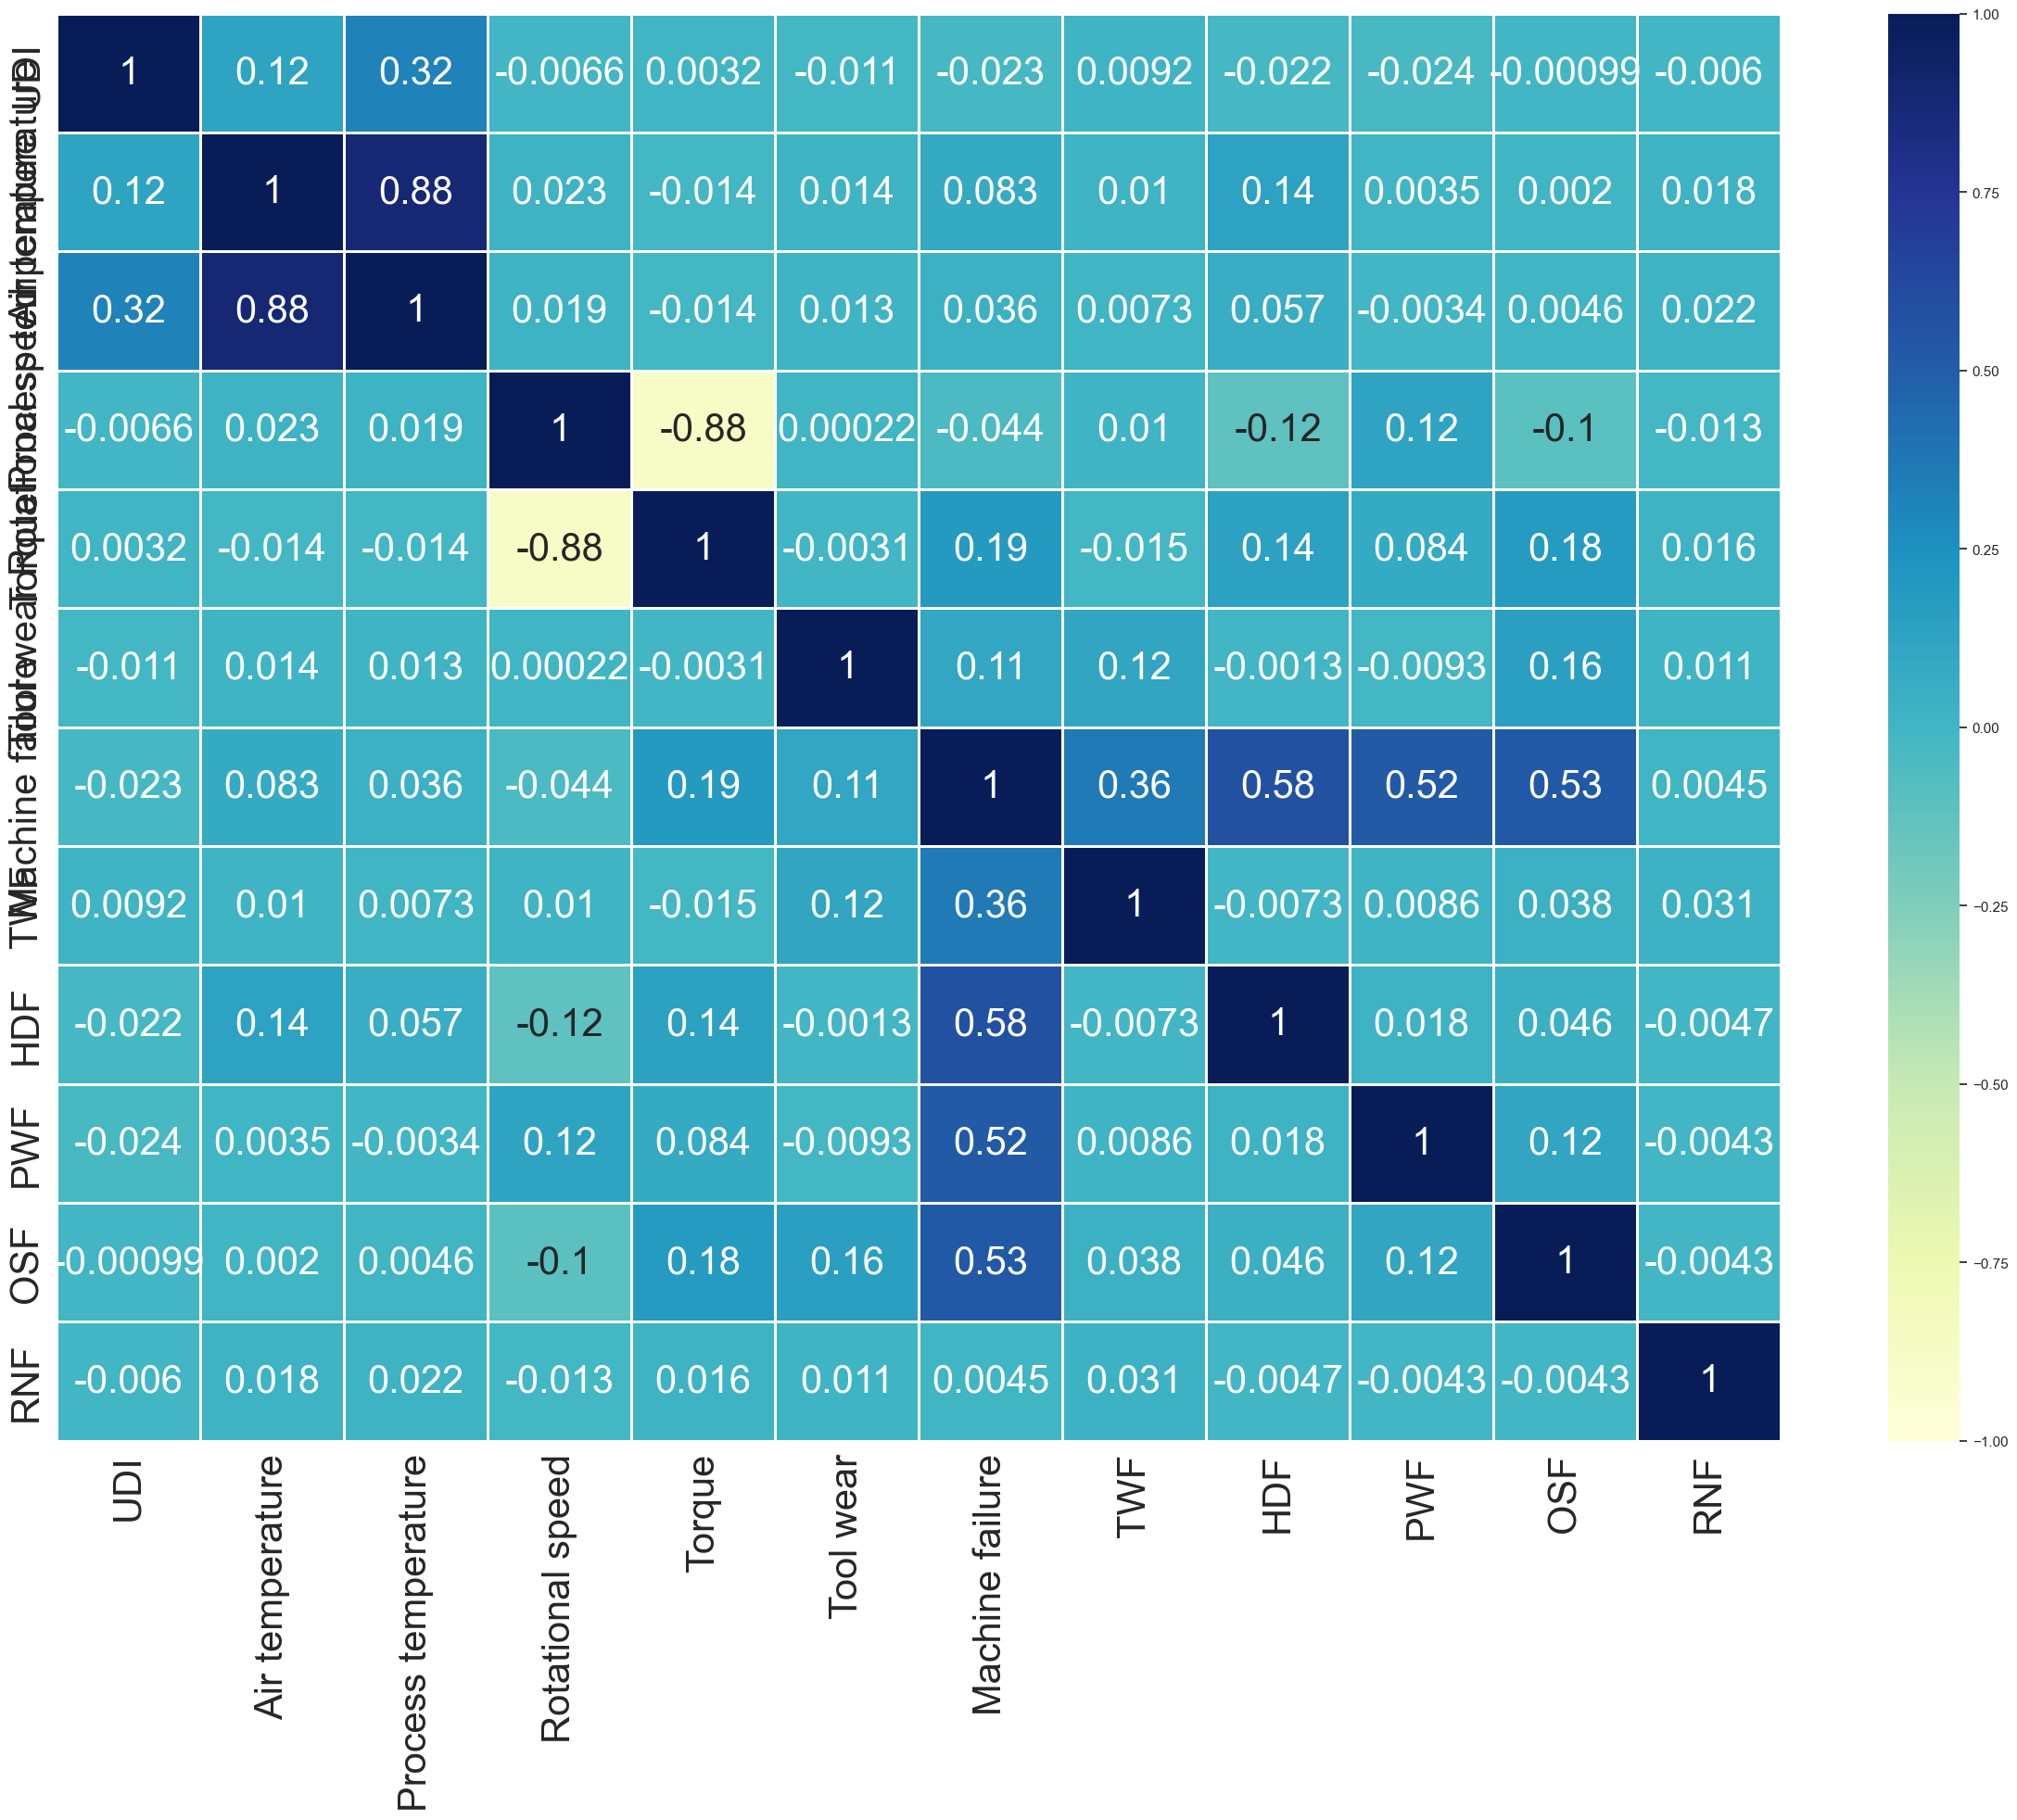

In [36]:
plt.rcParams['figure.figsize'] = (30, 20)
heatmap_df = sns.heatmap(df.corr(numeric_only=True), 
                         vmax=1., vmin=-1., 
                         annot=True, 
                         linewidths=.8, 
                         cmap='YlGnBu', 
                         annot_kws={"size": 30});
heatmap_df.set_xticklabels(heatmap_df.get_xticklabels(), size=30, rotation=90)
heatmap_df.set_yticklabels(heatmap_df.get_yticklabels(), size=30)
plt.show()

### Outliers
The method for eliminating outliers based on the Interquartile Range (IQR) will be used to identify and remove outliers vallues from numerical data. In addition, the data will be tested using a function that allows the upper defining value (e.g., 0.5%) of the value to be cut off, as well as the lower of the value to get rid of suspicious values.

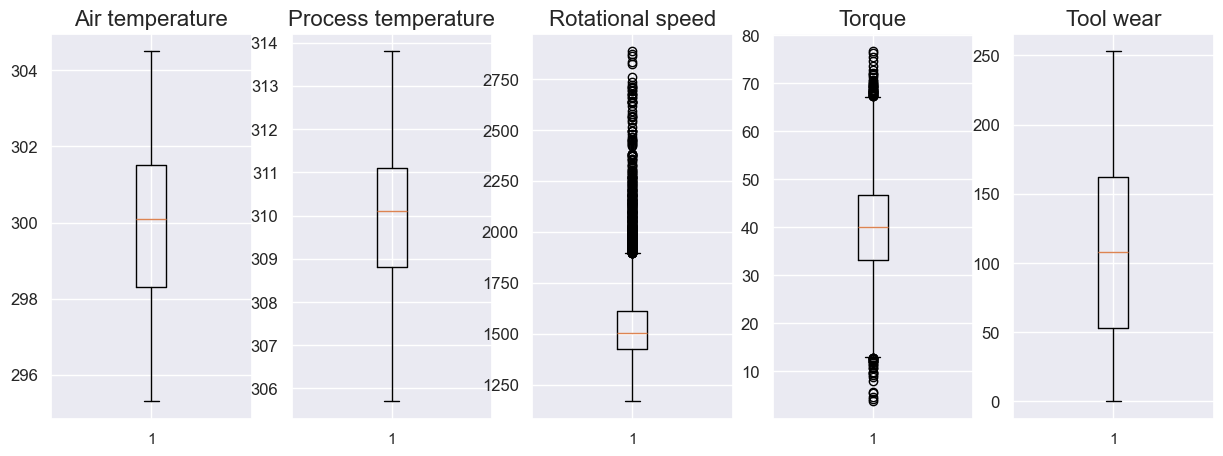

In [37]:
columns_plot = df.loc[:, 'Air temperature':'Tool wear'].columns
plt.figure(figsize=(15,5))
for i, col_name in enumerate(columns_plot):
    plt.subplot(1,len(columns_plot),i+1)
    plt.boxplot(df[col_name])
    plt.title(col_name, fontsize=16)
    plt.yticks(fontsize=12)
    plt.grid(True)

The above boxplot diagrams graphically represents the distribution of data by showing the central tendency (median), interquartile range (IQR), and potential outliers - values that deviate significantly from the rest of the data, are represented as individual points beyond the whiskers.

Function allows to cut off the upper defining value (e.g., 0.5%) of the value, as well as the lower value to get rid of suspicious values

In [38]:
# function for tabular representation of data and outliers,
# function allows to cut off the upper defining value (e.g., 0.5%) of the value, 
# as well as the lower value to get rid of suspicious values
def outliers_data_frame(df, columns_df, percentile=[0.5, 99.5], selection_iqr=False):
    columns_data_frame = ['Col_name', 'Min', 'Max', 'Limit_low', 'Limit_high', 'Qty_outliers']
    df_percentile = pd.DataFrame(columns=columns_data_frame)
    
    def percentile_modeling(low, high, data):
        if data < low:
            data = low
        elif data > high:
            data = high
        return data
    
    for i, col_name in enumerate(columns_df):    
        if selection_iqr:
            iqr = np.nanpercentile(df[col_name], 75) - np.nanpercentile(df[col_name], 25)
            low_sel = (np.nanpercentile(df[col_name], 25) - 1.5 * iqr)
            high_sel = (np.nanpercentile(df[col_name], 75) + 1.5 * iqr) 
        else:
            low_sel = round(np.percentile(df[col_name], percentile[0]))
            high_sel = round(np.percentile(df[col_name], percentile[1]))
        y_no_outliers = df[col_name].copy()
        y_no_outliers = y_no_outliers.apply(lambda x: percentile_modeling(low_sel, high_sel, x))
        qty_outliers = (df[col_name] != y_no_outliers).sum()

        data_to_add = pd.DataFrame({
            'Col_name': [col_name],
            'Min': [np.min(df[col_name])],
            'Max': [np.max(df[col_name])],
            'Limit_low': [low_sel],
            'Limit_high': [high_sel],
            'Qty_outliers': [qty_outliers]
        })
        df_percentile = pd.concat([df_percentile, data_to_add], axis=0, ignore_index=True)
    return df_percentile

In [39]:
# table showing summary for cutoff of observations covering 5% of upper and lower data values
outliers_data_frame(df=df, 
                    columns_df=df.loc[:, 'Air temperature':'Tool wear'].columns, 
                    percentile=[0.5, 99.5],
                   selection_iqr=False)

,Col_name,Min,Max,Limit_low,Limit_high,Qty_outliers
0,Air temperature,295.3,304.5,296,304,218
1,Process temperature,305.7,313.8,306,313,208
2,Rotational speed,1168.0,2886.0,1256,2372,100
3,Torque,3.8,76.6,14,66,93
4,Tool wear,0.0,253.0,0,229,45


#### The method for eliminating outliers based on the Interquartile Range (IQR) 

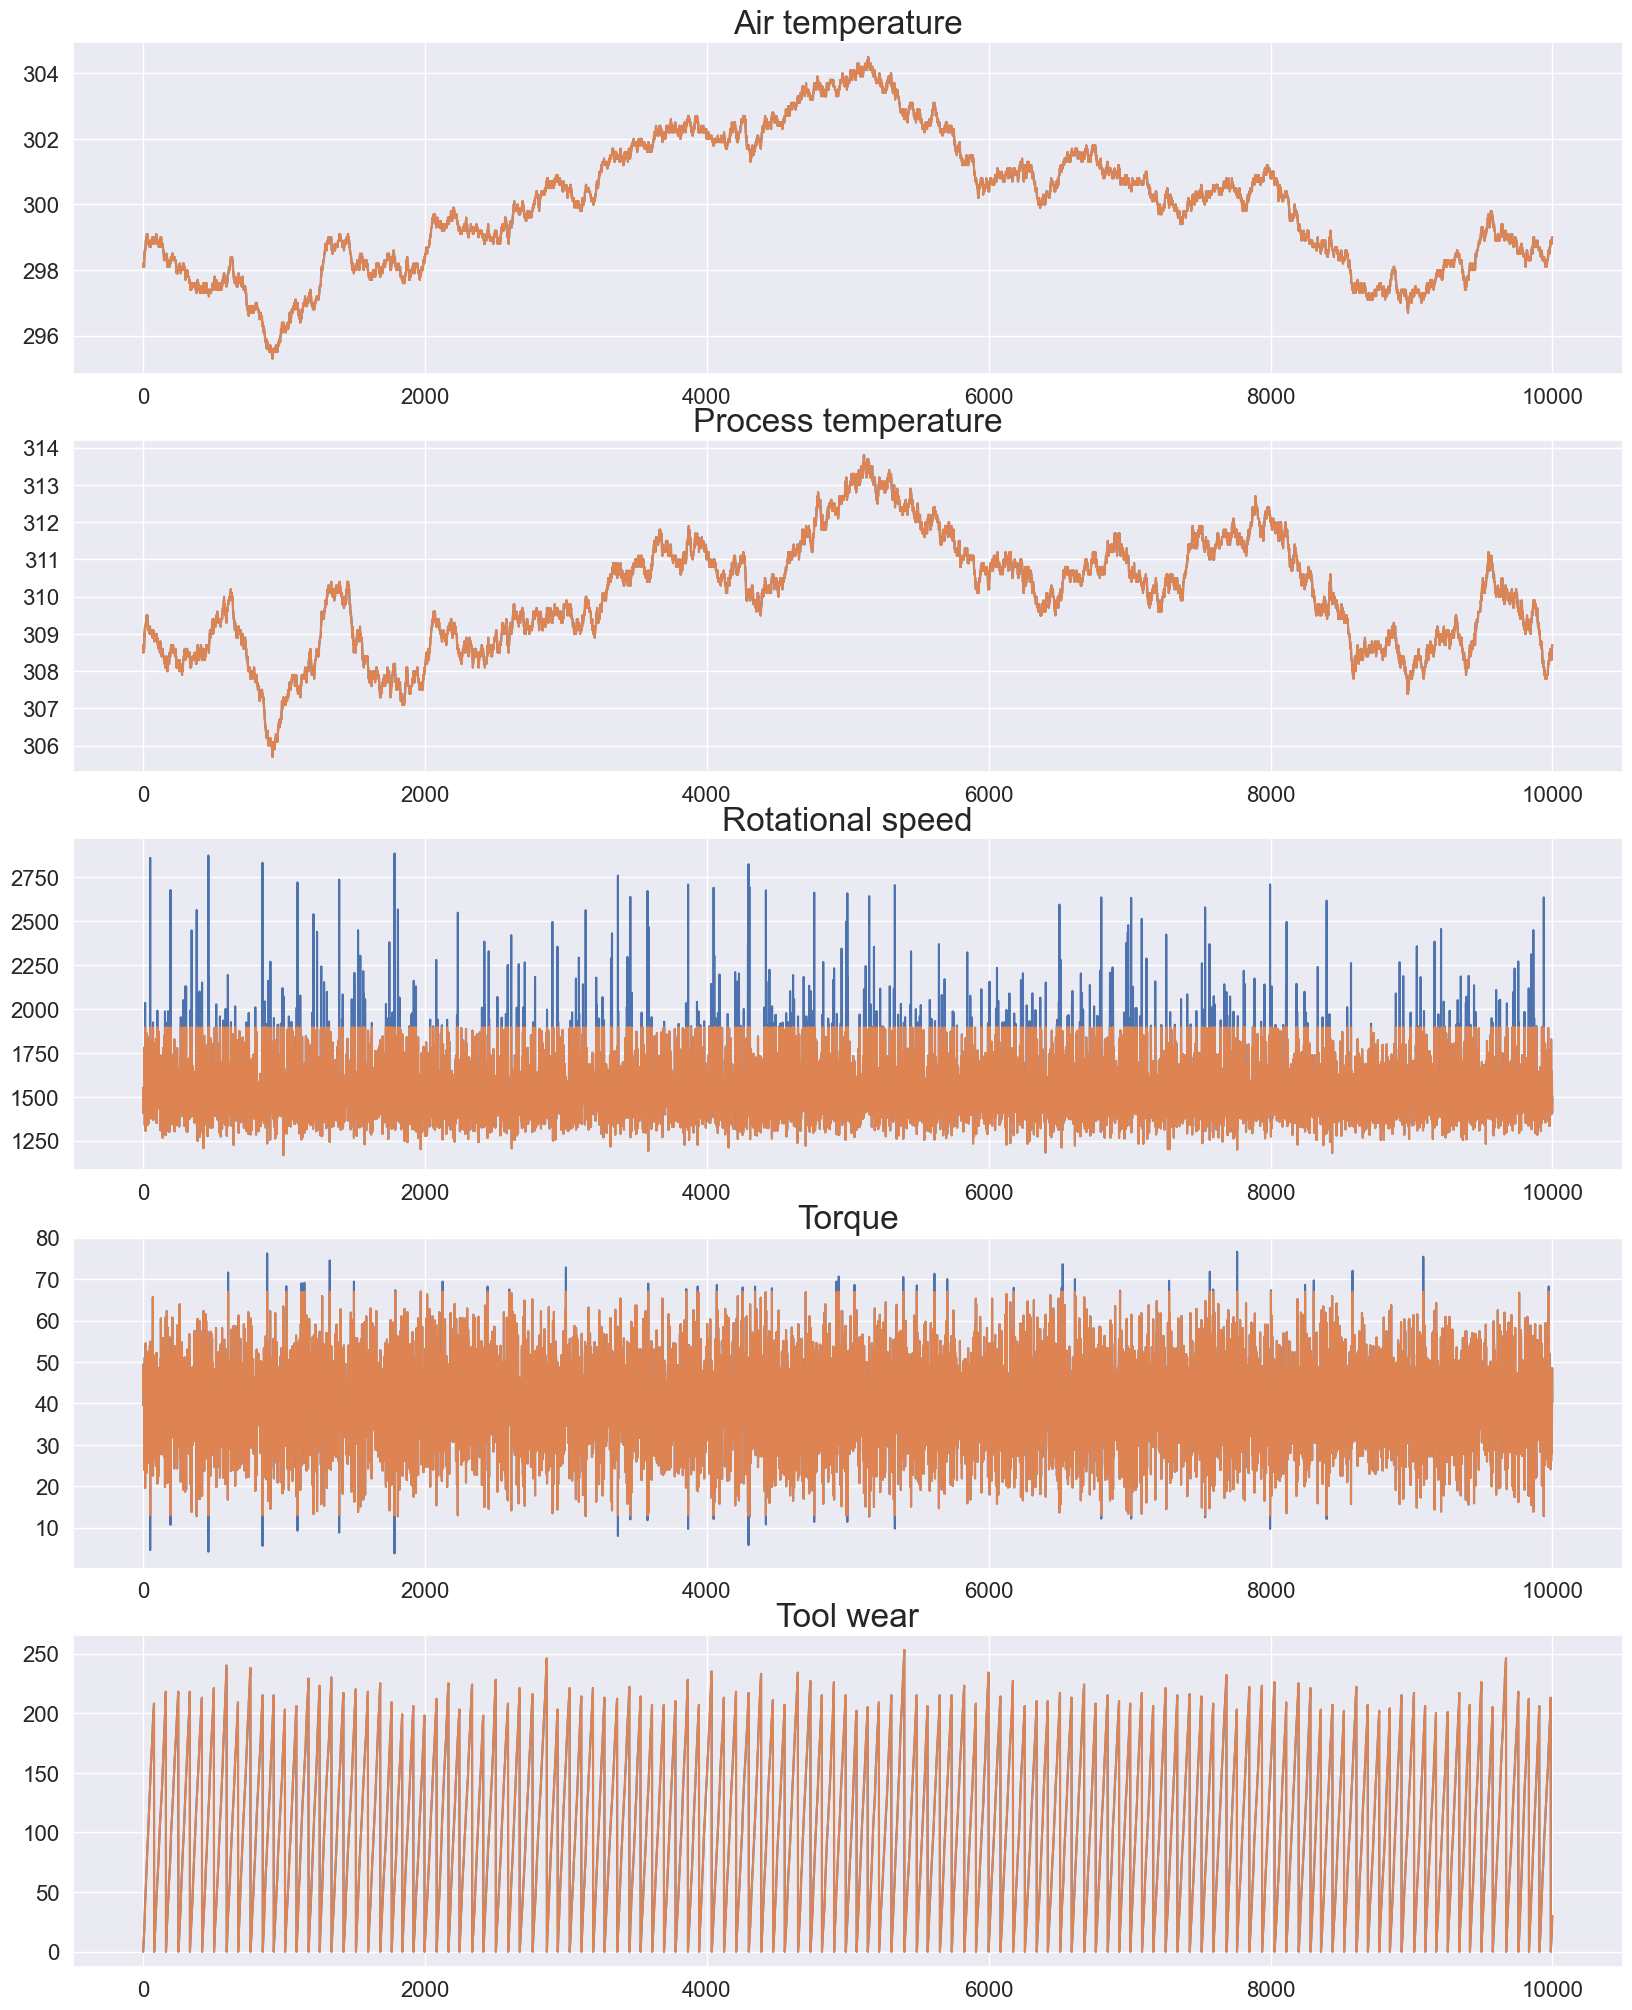

In [40]:
plt.figure(figsize=(20,25))
for i, col_name in enumerate(columns_plot):
    plt.subplot(len(columns_plot),1,i+1)
    
    iqr = np.nanpercentile(df_num_transf[col_name], 75) - np.nanpercentile(df_num_transf[col_name], 25)
    low = (np.nanpercentile(df_num_transf[col_name], 25) - 1.5 * iqr)
    high = (np.nanpercentile(df_num_transf[col_name], 75) + 1.5 * iqr) 
#     low,  = round(np.percentile(df[col_name], 0.5))
#     high = round(np.percentile(df[col_name], 99.5))

    def percentile_modeling(low, high, data):
        if data < low:
            data = low
        elif data > high:
            data = high
        return data
    y_no_outliers = df[col_name].copy()
    y_no_outliers = y_no_outliers.apply(lambda x: percentile_modeling(low, high, x))
    
    plt.plot(df[col_name])
    plt.plot(y_no_outliers)
    plt.title(col_name,  fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

The above graphs show data plots after applying IQR-based outlier elimination. 

Potential outliers are located at column: 'Rotational speed' and 'Torque'	

In [41]:
# table showing summary for cutoff of observations based on IQR method
outliers_data_frame(df=df, 
                    columns_df=df.loc[:, 'Air temperature':'Tool wear'].columns, 
                    percentile=[0.5, 99.5],
                   selection_iqr=True)

,Col_name,Min,Max,Limit_low,Limit_high,Qty_outliers
0,Air temperature,295.3,304.5,293.50,306.30,0
1,Process temperature,305.7,313.8,305.35,314.55,0
2,Rotational speed,1168.0,2886.0,1139.50,1895.50,418
3,Torque,3.8,76.6,12.80,67.20,69
4,Tool wear,0.0,253.0,-110.50,325.50,0


In [42]:
class RemoveOutliersTransformerPercentOrIqr(BaseEstimator, TransformerMixin):
    def __init__(self, percentiles=[1, 99], columns=[], selection_iqr=False):
        self.percentiles = percentiles
        self.columns = columns
        self.lower = []
        self.upper = []
        self.selection_iqr = selection_iqr
        
    def percentile_modeling(self, low, high, data):
        if data < low:
            data = low
        elif data > high:
            data = high
        return data
    
    def fit(self, X, y=None):    
        if self.selection_iqr:
            for col in self.columns:
                iqr = np.nanpercentile(X[col], 75) - np.nanpercentile(X[col], 25)
                self.lower.append(np.nanpercentile(X[col], 25) - 1.5 * iqr)
                self.upper.append(np.nanpercentile(X[col], 75) + 1.5 * iqr)
        else:    
            for col in self.columns:
                self.lower.append(round(np.percentile(X[col], self.percentiles[0])))
                self.upper.append(round(np.percentile(X[col], self.percentiles[1])))
        return self
    
    def transform(self, X, y=None):
        for low, high, col in zip(self.lower, self.upper, self.columns):
            X[col] = X[col].apply(lambda x: self.percentile_modeling(low, high, x))
        return X

The above class allows you to cut outliers based on the declared percentile or IQR method.

In [43]:
columns_to_remove = ['UDI']
outliers_to_remove = ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']
percentile = [0.5, 99.5]

steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='numeric')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('other_fault_added', OtherFaultLabelTransformer()),   
    ('missing_failure_added', MissingFailureTransformer()),
    ('remove_outliers', RemoveOutliersTransformerPercentOrIqr(percentiles=percentile, 
                                                              columns=outliers_to_remove, 
                                                              selection_iqr=True))
]
pipeline_num = Pipeline(steps=steps)
df_num_transf = pipeline_num.fit_transform(df)

#### Charts showing the result of using the IQR method to eliminate outlliers

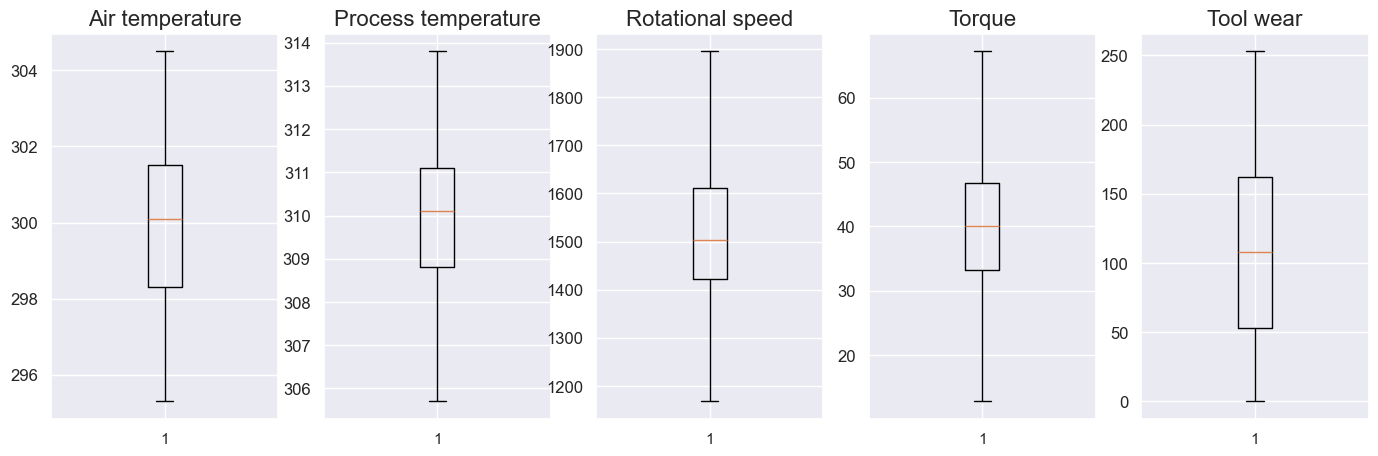

In [44]:
columns_plot = df_num_transf.loc[:, 'Air temperature':'Tool wear'].columns
plt.figure(figsize=(17,5))
for i, col_name in enumerate(columns_plot):
    plt.subplot(1,len(columns_plot),i+1)
    plt.boxplot(df_num_transf[col_name])
    plt.title(col_name, fontsize=16)
    plt.yticks(fontsize=12)
    plt.grid(True)

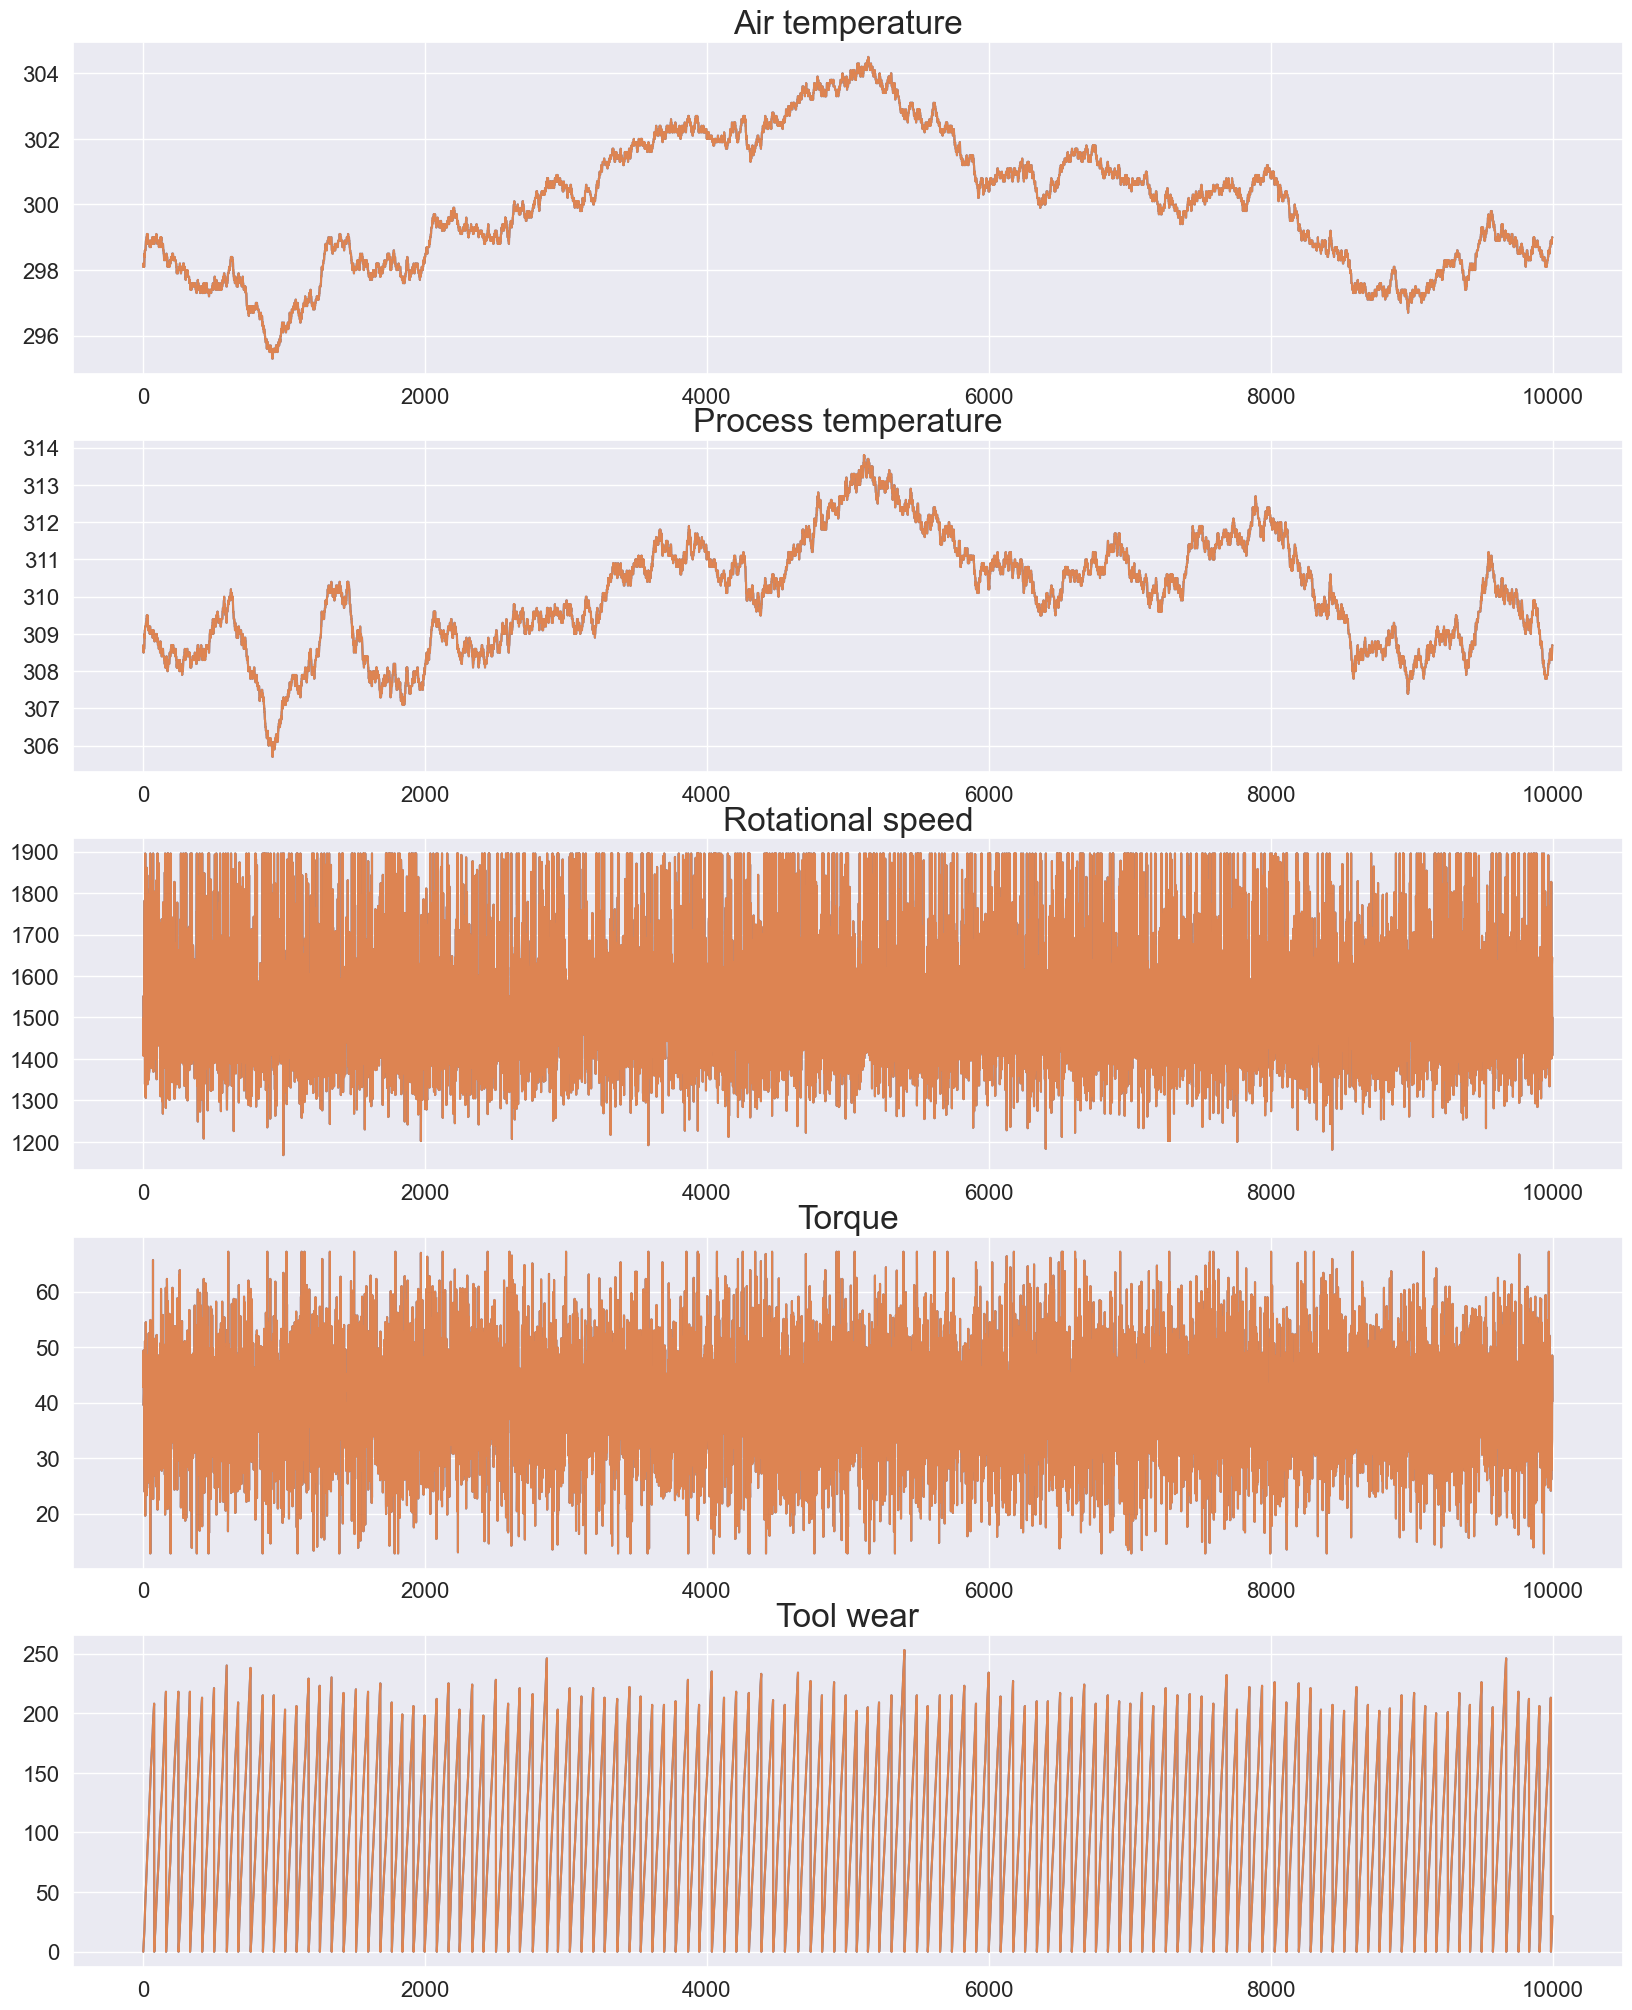

In [45]:
plt.figure(figsize=(20,25))
for i, col_name in enumerate(columns_plot):
    plt.subplot(len(columns_plot),1,i+1)

    iqr = np.nanpercentile(df_num_transf[col_name], 75) - np.nanpercentile(df_num_transf[col_name], 25)
    low = (np.nanpercentile(df_num_transf[col_name], 25) - 1.5 * iqr)
    high = (np.nanpercentile(df_num_transf[col_name], 75) + 1.5 * iqr)     
#     low = round(np.percentile(df_num_transf[col_name], 0.5))
#     high = round(np.percentile(df_num_transf[col_name], 99.5))

    def percentile_modeling(low, high, data):
        if data < low:
            data = low
        elif data > high:
            data = high
        return data
    y_no_outliers = df_num_transf[col_name].copy()
    y_no_outliers = y_no_outliers.apply(lambda x: percentile_modeling(low, high, x))
    
    plt.plot(df_num_transf[col_name])
    plt.plot(y_no_outliers)
    plt.title(col_name, fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

### Scaling data
For our case, several types of scaling will be checked such as: MinMaxScaler, StandardScaler or PowerTransformer used method: Box-Cox and Yeo-Johnson.

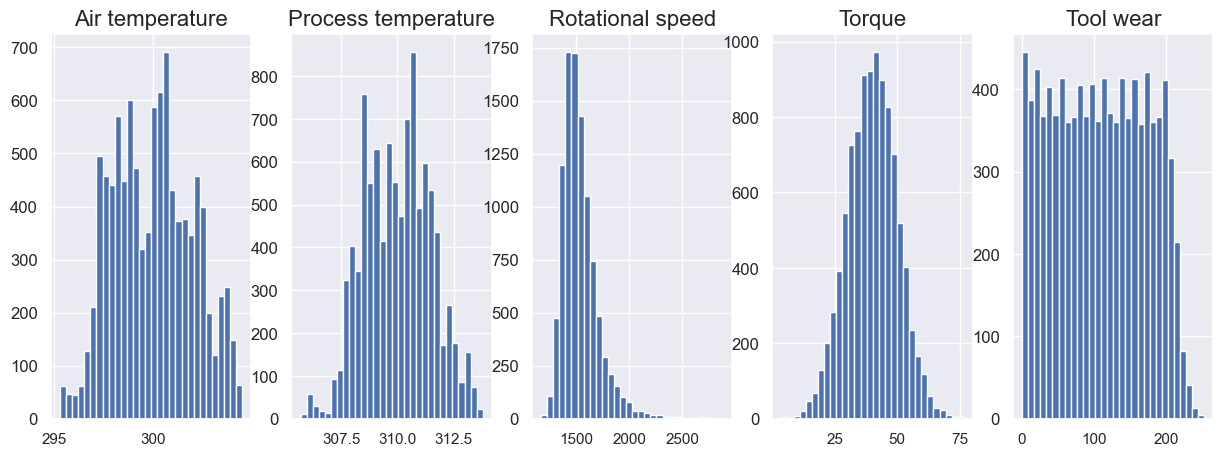

In [46]:
columns_plot = df.loc[:, 'Air temperature':'Tool wear'].columns
plt.figure(figsize=(15,5))
for i, col_name in enumerate(columns_plot):
    plt.subplot(1,len(columns_plot),i+1)
    df[col_name].hist(bins=30)
    plt.title(col_name, fontsize=16)
    plt.yticks(fontsize=12)
    plt.grid(True)

In [47]:
class TollWearValueAddTransformer(BaseEstimator, TransformerMixin):
    def __init__( self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        X['Tool wear'] = X['Tool wear'] + 0.000001
        return X

In [48]:
df = pd.read_csv('Data_UCI/ai4i2020.csv')

columns_to_remove = ['UDI']
outliers_to_remove = ['Air temperature', 'Process temperature', 'Torque', 'Tool wear'] #'Rotational speed',
columns_target = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'OTHER_F']
columns_to_scale = ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']
percentile = [0.5, 99.5]
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='numeric')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('other_fault_added', OtherFaultLabelTransformer()),   
    ('missing_failure_added', MissingFailureTransformer()),
    ('remove_outliers', RemoveOutliersTransformerPercentOrIqr(percentiles=percentile, 
                                                              columns=outliers_to_remove,
                                                              selection_iqr=True)),
    ('drop_columns_target', RemoveColumnsTransformer(columns_to_remove=columns_target)),
#     ('scaling_std', StandardScaler()),
#     ('scaling_min_max', MinMaxScaler()),
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
#     ('add_val_ToolWear', TollWearValueAddTransformer()),
#     ('power_transformer', PowerTransformer(method='box-cox', standardize=True))
]
pipeline_num = Pipeline(steps=steps)
df_num_transf = pipeline_num.fit_transform(df)
df_num_transf_pd = pd.DataFrame(df_num_transf, columns=columns_to_scale)
df_num_transf_pd.head()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
0,-1.387779e-15,-0.947045,0.310037,0.283962,-2.106867
1,-1.332268e-15,-0.879238,-0.803251,0.637053,-1.964290
2,-1.387779e-15,-1.014882,-0.051535,0.949816,-1.889161
3,-1.332268e-15,-0.947045,-0.574544,-0.048920,-1.821417
4,-1.332268e-15,-0.879238,-0.803251,0.001515,-1.758683


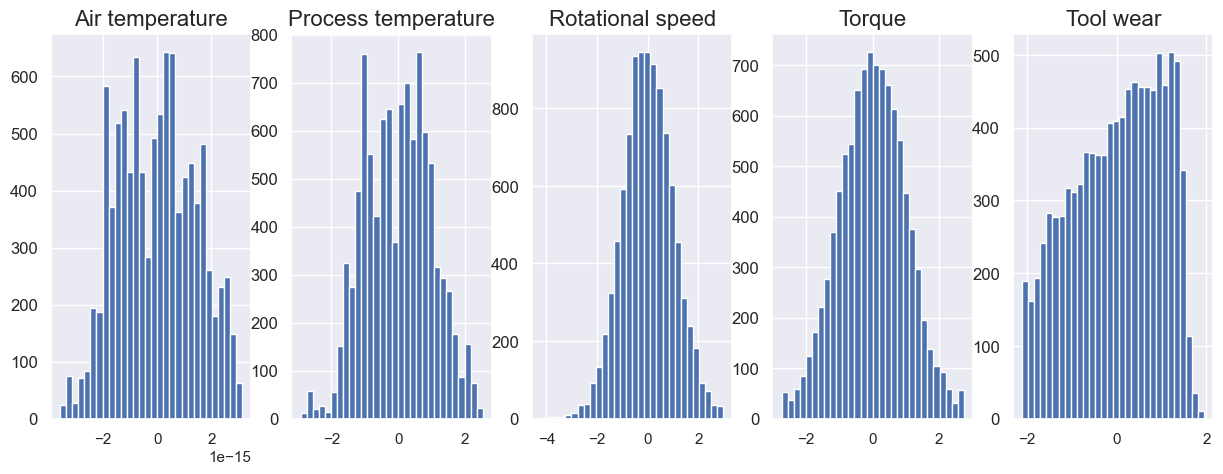

In [49]:
columns_plot = columns_to_scale
plt.figure(figsize=(15,5))
for i, col_name in enumerate(columns_plot):
    plt.subplot(1,len(columns_plot),i+1)
    df_num_transf_pd[col_name].hist(bins=30)
    plt.title(col_name, fontsize=16)
    plt.yticks(fontsize=12)
    plt.grid(True)

Transformation numeric data by PowerTransformer give us good result regarding 'Rotational speed' or 'Torque' features, which allowed to obtain a normal distribution. Other distributions are not characteristic what can be referred to as "irregular". Box-Cox method is available only for positives values, so 'Tool wear' column have been modifed using dedicated transformer: TollWearValueAddTransformer.

### Dimensionality reduction

In [50]:
df = pd.read_csv('Data_UCI/ai4i2020.csv')

columns_to_remove = ['UDI']
outliers_to_remove = ['Air temperature', 'Process temperature',  'Torque', 'Tool wear'] # 'Rotational speed',
columns_target = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'OTHER_F']
percentile = [0.5, 99.5]
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='numeric')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('other_fault_added', OtherFaultLabelTransformer()),   
    ('missing_failure_added', MissingFailureTransformer()),
    ('remove_outliers', RemoveOutliersTransformerPercentOrIqr(percentiles=percentile, 
                                                              columns=outliers_to_remove,
                                                              selection_iqr=True)),
    ('drop_columns_target', RemoveColumnsTransformer(columns_to_remove=columns_target)),
#     ('scaling_std', StandardScaler()),
#     ('scaling_min_max', MinMaxScaler()),
#     ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
    ('add_val_ToolWear', TollWearValueAddTransformer()),
    ('power_transformer', PowerTransformer(method='box-cox', standardize=True)),
    ('PCA', PCA(n_components=0.9))
]
pipeline_num = Pipeline(steps=steps)
df_num_transf = pipeline_num.fit_transform(df)

In [51]:
df_num_transf

array([[ 0.01176861,  2.49072827,  1.11026383],
       [ 1.04563527,  2.15012766,  0.90676869],
       [ 0.73850138,  2.16138025,  0.72086991],
       ...,
       [-1.03444482,  1.69684124,  0.29637275],
       [ 1.20055486,  1.54699642,  0.32421767],
       [ 0.06679361,  1.47753528,  0.21569381]])

PCA (Principal Component Analysis) used for dimensionality reduction transforms the original features into a new set of uncorrelated features called principal components. The parameter: n_components defines the number of principal components to retain after the dimensionality reduction. In current case it set to a specific number like 0.9, what means I want to retain enough components to explain 90% of the variance in the data. This allows to reduce 5 feaures to 3.

### Transforming data for categorical features

#### Encoding categorical variables

In [52]:
df = pd.read_csv('Data_UCI/ai4i2020.csv')
df.head(0)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF


In [53]:
df = pd.read_csv('Data_UCI/ai4i2020.csv')

columns_to_remove_cat = ['Product ID']
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove_cat)),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='object')),
    ('encoding_cat', OneHotEncoder(sparse=False, handle_unknown='ignore'))
]
pipeline_cat = Pipeline(steps=steps)
df_cat_transf = pipeline_cat.fit_transform(df)
df_cat_transf

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

### Handling imbalanced data
- calculation class weights 

In [57]:
# read data from csv file
df = pd.read_csv('Data_UCI/ai4i2020.csv')
# first pipeline to modify data before preprocessing
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('other_fault_added', OtherFaultLabelTransformer()),   
    ('missing_failure_added', MissingFailureTransformer()),
    ('select_columns_type', SelectColumnsByTypeTransformer(type_to_select='numeric'))
]
pipeline_trans = Pipeline(steps=steps)
df_transformed = pipeline_trans.fit_transform(df)
df_transformed.head(0)

,UDI,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF,OTHER_F


In [58]:
# Data division, class weights calculation:
columns_targets = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'OTHER_F']
X = df_transformed.drop(columns_targets, axis=1)
y = df_transformed['Machine failure']
# split data into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    stratify=df['Machine failure'],
                                                    random_state=42)

print(f'Number of samples per class for the target: {y_train.value_counts()}')

Number of samples per class for the target: Machine failure
0    7714
1     286
Name: count, dtype: int64


In [59]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print(f'Class weights calculated: {class_weights}')

Class weights calculated: [ 0.51853772 13.98601399]


In [60]:
# implementation in model:
model = DecisionTreeClassifier(class_weight={0:class_weights[0], 1:class_weights[1]})

- The class_weight the parameter is used to adjust the weights of different classes in the training data to handle imbalanced class distribution. The class_weight parameter can be set to either "balanced" or a dictionary of weights for each class.

- The balanced option is used to automatically adjust the weights based on the class distribution in the data.

### Handling imbalanced data
- SMOTE for imbalanced classes - oversampling

SMOTE works by generating synthetic examples for the minority class. It does this by creating synthetic instances along the line segments joining existing minority class instances. 

In [61]:
# SMOTE for imbalanced classes - oversampling:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [62]:
print(f'Number of samples per class after oversampling SMOTE: {y_train_resampled.value_counts()}')

Number of samples per class after oversampling SMOTE: Machine failure
0    7714
1    7714
Name: count, dtype: int64


## Final model training - test 1 
- Decision Tree Classifier.
- Using Column Transformer for procesing categorical and numeric columns independently.
- Class weights calculation for imbalanced classes: compute_class_weight().
- Model trained with using GridSearch scoring: 'recall'.
- All features used for training: numeric and categorical.

In [63]:
# Read data from csv file
df = pd.read_csv('Data_UCI/ai4i2020.csv')
# First pipeline to modify data before preprocessing
steps = [
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('fault_without_type_remove', FaultWithoutTypeRemoverTransformer()),
        # Creating a new label for alarms without assignment:
#     ('other_fault_label_added', OtherFaultLabelTransformer()),
        # Create a new label for alarms without assignment:
#     ('missing_failure_added', MissingFailureTransformer()) # create a new label for alarms without assignment:
]
pipeline_trans = Pipeline(steps=steps)
df_transformed = pipeline_trans.fit_transform(df)
df_transformed.head(0)

,UDI,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF


In [64]:
# Data division, class weights calculation:
columns_targets = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'] # 'OTHER_F'
X = df_transformed.drop(columns_targets, axis=1)
y = df_transformed['Machine failure']
# Split data into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
# Class weights calculation for imbalanced classes:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
(f'Class weights: {class_weights}')

'Class weights: [ 0.51708075 15.13636364]'

In [66]:
# Transformer numeric
columns_to_remove_num = ['UDI']
outliers_to_remove = ['Air temperature', 'Process temperature', 
                      'Rotational speed', 'Torque', 'Tool wear'] # 'Rotational speed' 
percentile = [1.5, 98.5]
transformer_numeric = Pipeline(steps=[
    ('select_columns_type_num', SelectColumnsByTypeTransformer(type_to_select='numeric')),
    ('drop_columns_num', RemoveColumnsTransformer(columns_to_remove=columns_to_remove_num)),
    ('remove_outliers', RemoveOutliersTransformerPercentOrIqr(percentiles=percentile, 
                                                              columns=outliers_to_remove,
                                                              selection_iqr=True)),
    # New features:
#     ('new_feature_power', NewFeaturePowerTransformer()),
#     ('new_feature_TorqProcTemp', NewFeatureTorqTempProcTransformer()),
#     ('new_feature_RotSpeedProcTemp', NewFeatureRotTempProcTransformer()),
    # Not recommended for use with decision trees or models based on gradient boosting (only for test):
#     ('scaling_std', StandardScaler()),
#     ('scaling_min_max', MinMaxScaler()),
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
#     ('add_val_ToolWear', TollWearValueAddTransformer()), # used for method: 'box-cox'
#     ('power_transformer', PowerTransformer(method='box-cox', standardize=True)),
    # Not recommended for use with decision trees or models based on gradient boosting (only for test):
#     ('PCA', PCA(n_components=0.9))
])

# Transformer categorical
columns_to_remove_cat = ['Product ID'] # 'Type'
transformer_categorical = Pipeline(steps=[
    ('select_columns_type_cat', SelectColumnsByTypeTransformer(type_to_select='object')),
    ('drop_columns_cat', RemoveColumnsTransformer(columns_to_remove=columns_to_remove_cat)),
    ('encoding_cat', OneHotEncoder(handle_unknown='ignore')) # sparse=False,
])

# Transformer final
numeric_columns = ['UDI', 'Air temperature', 'Process temperature',
                   'Rotational speed', 'Torque', 'Tool wear']
cat_columns = ['Product ID', 'Type']
transformer_final = ColumnTransformer(transformers=[
    ('numeric', transformer_numeric, numeric_columns), 
    ('categorical', transformer_categorical, cat_columns)
])
# Optimizer
model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    "max_depth": [3, 4, 5], # None
    "min_samples_leaf": [10, 12, 14, 16],
    'min_samples_split': [2, 4, 6, 12],
    "class_weight": [{0:1, 1:1}, {0:class_weights[0], 1:class_weights[1]}]  
    }
optimizer = GridSearchCV(model, 
                         param_grid, 
                         cv=7, 
                         scoring='recall', #'accuracy', 'precision', 'recall', 'f1', 'roc_auc'
                         n_jobs=-1)

# Final pipeline with model
pipeline = Pipeline(steps=[('preprocessor', transformer_final),
#                            ('PCA', PCA(n_components=0.9)),
                           ('optimizer', optimizer)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('select_columns_type_num',
                                                                   SelectColumnsByTypeTransformer(type_to_select='numeric')),
                                                                  ('drop_columns_num',
                                                                   RemoveColumnsTransformer(columns_to_remove=['UDI'])),
                                                                  ('remove_outliers',
                                                                   RemoveOutliersTransformerPercentOrIqr(columns=['Air '
                                                                                                                  'temperature',
                                                                                                                  'Process '
                                                                                                                  'temper...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Product ID', 'Type'])])),
                ('optimizer',
                 GridSearchCV(cv=7, estimator=DecisionTreeClassifier(),
                              n_jobs=-1,
                              param_grid={'class_weight': [{0: 1, 1: 1},
                                                           {0: 0.5170807453416149,
                                                            1: 15.136363636363637}],
                                          'criterion': ['gini', 'entropy'],
                                          'max_depth': [3, 4, 5],
                                          'min_samples_leaf': [10, 12, 14, 16],
                                          'min_samples_split': [2, 4, 6, 12],
                                          'splitter': ['best', 'random']},
                              scoring='recall'))])

In [67]:
# Metrics
preds = pipeline.predict(X_test)
metrics = [accuracy_score, precision_score, recall_score, f1_score]
metrics_name = ['Accuracy', 'Precision', 'Recall', 'F1']
for metric, name in zip(metrics, metrics_name):
    print(f'{name}: {round(metric(y_test, preds),3)}')
# Classifications report    
print('Classification report:')
print(classification_report(y_test, preds, digits = 3))

Accuracy: 0.875
Precision: 0.206
Recall: 0.98
F1: 0.341
Classification report:
              precision    recall  f1-score   support

           0      0.999     0.871     0.931      2899
           1      0.206     0.980     0.341        99

    accuracy                          0.875      2998
   macro avg      0.603     0.926     0.636      2998
weighted avg      0.973     0.875     0.911      2998



- The model was evaluated by a metric: 'recall' due to the cost of false negatives is high.
- Using GridSearch allows to select the best model parameters from the grid. The results are shown below.

In [68]:
# The best parameters for model:
print(f'Best parameters for mmodel: {optimizer.best_params_}')
print(f'Number of features used to train model: {optimizer.n_features_in_}')

Best parameters for mmodel: {'class_weight': {0: 0.5170807453416149, 1: 15.136363636363637}, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
Number of features used to train model: 8


#### Evaluation of classifiers: AUC-ROC
AUC-ROC curve ('Receiver Operating Characteristic')

ROC AUC score: 0.962


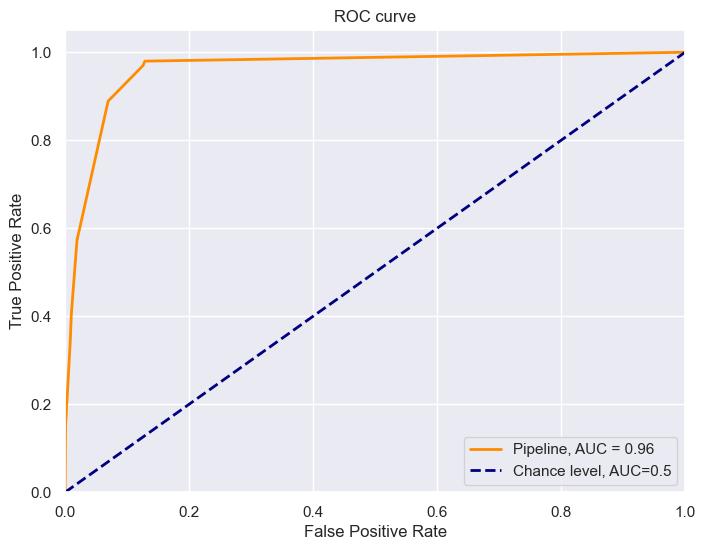

In [69]:
# Prediction on test data
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
# Calculation of roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC score: {roc_auc.round(3)}')
# AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# ROC curve plot
plt.figure(figsize=(8, 6))
label = type(pipeline).__name__ + f', AUC = {roc_auc:.2f}'
plt.plot(fpr, tpr, color='darkorange', lw=2, label=label)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=f'Chance level, AUC=0.5')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

- The Area Under the Receiver Operating Characteristic Curve (ROC AUC) is a measure of the quality of a binary classifier, assessing its ability to distinguish between two classes. ROC AUC evaluates the area under the Receiver Operating Characteristic curve, which depicts the relationship between the True Positive Rate (TPR) and the False Positive Rate (FPR) at various thresholds used for classification.

#### Features importances

In [70]:
# Model with the best parameters
best_model = pipeline.named_steps['optimizer'].best_estimator_
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    print("Feature Importances:")
    print(feature_importances)  
else:
    print("Model has no attribute: 'feature_importances_'")

Feature Importances:
[0.         0.03495877 0.28823323 0.41307467 0.26248947 0.
 0.00124387 0.        ]


In [71]:
# Numeric features name
numeric_feature_names = [str(i) for i in pipeline.named_steps['preprocessor'].transformers_[0][2]]
print(f'Numeric features name: {numeric_feature_names[1:]}')
# Categorical features name:
cat_feature_names = [str(i) for i in pipeline.named_steps['preprocessor'].transformers_[1][2]]
print(f'Categorical features name: {cat_feature_names}')
# Features final after preprocessing
new_col = ['Power newCol', 'TorqTemp newCol', 'RotTemp newCol'] #1 'Power newCol', #3 'RotTemp newCol'
num_col_after_processing = [item for item in numeric_feature_names if item not in columns_to_remove_num]
cat_col_after_processing = [item for item in cat_feature_names if item not in columns_to_remove_cat]
features_final = num_col_after_processing + cat_col_after_processing*df['Type'].nunique()
print(f'Features final: {features_final}')
# Data frame with sorted values
pd.DataFrame({
        'Features': (features_final),
        'Importances[%]': (best_model.feature_importances_.round(3)*100),
}).sort_values(by='Importances[%]', ascending=False).reset_index().drop(columns='index')

Numeric features name: ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']
Categorical features name: ['Product ID', 'Type']
Features final: ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear', 'Type', 'Type', 'Type']


,Features,Importances[%]
0,Torque,41.3
1,Rotational speed,28.8
2,Tool wear,26.2
3,Process temperature,3.5
4,Type,0.1
5,Air temperature,0.0
6,Type,0.0
7,Type,0.0


Model used in this case allow to check features importances. The first 4 features provide us with more than 99% of the information we need for the case under study, so the number of features will be reduced to this number to simplify the model in next iterations.

## Final model training - test 2
- Decision Tree Classifier.
- SMOTE for imbalanced classes - oversampling.
- Model trained with using GridSearch scoring: 'roc_auc'.
- Number of features reduced to the 5 most significant.
- Pipeline transformer rebuilt, simplified.

In [72]:
# Read data from csv file
df = pd.read_csv('Data_UCI/ai4i2020.csv')
# Pipeline to modify data before training
columns_to_remove_num = ['UDI']
columns_to_remove_cat = ['Product ID', 'Type']
columns_to_remove_all = columns_to_remove_cat + columns_to_remove_num
outliers_to_remove = ['Process temperature',
                      'Air temperature',
#                       'Rotational speed',
                      'Torque', 'Tool wear']
percentile = [1.5, 98.5]
steps = [
        # General changes in the data set:
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('fault_without_type_remove', FaultWithoutTypeRemoverTransformer()),
        # Adding alarms to the target from the alarm type columns:
#     ('other_fault_label_added', OtherFaultLabelTransformer()), 
        # Adding alarms to the target from the alarm type columns:
    ('missing_failure_added', MissingFailureTransformer()),
        # Litle value aded for 'ToolWear' column - important for method: 'box-cox':
#     ('add_val_ToolWear', TollWearValueAddTransformer()), 
        # Changes in numeric data:
    ('drop_columns_num', RemoveColumnsTransformer(columns_to_remove=columns_to_remove_all)),
    ('remove_outliers', RemoveOutliersTransformerPercentOrIqr(percentiles=percentile, 
                                                              columns=outliers_to_remove,
                                                              selection_iqr=True)),
    # New features:
#     ('new_feature_power', NewFeaturePowerTransformer()),
#     ('new_feature_TorqProcTemp', NewFeatureTorqTempProcTransformer()),
#     ('new_feature_RotSpeedProcTemp', NewFeatureRotTempProcTransformer()),
]
pipeline_trans = Pipeline(steps=steps)
df_transformed = pipeline_trans.fit_transform(df)
df_transformed.head(0)

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF


In [73]:
# Data division, class weights calculation:
columns_drop = df_transformed.loc[:,'Machine failure':].columns
X = df_transformed.drop(columns_drop, axis=1)
y = df['Machine failure']
# split data into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
# Class weights calculation for imbalanced classes:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
(f'Class weights: {class_weights}')
# SMOTE for imbalanced classes - oversampling:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Optimizer
model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    "max_depth": [5, 8, 10], # None
    "min_samples_leaf": [3, 5, 8, 10],
    'min_samples_split': [3, 6, 10, 12],
        # Parameter not used due to use of oversampling SMOTE:
    "class_weight": [{0:1, 1:1}] # {0:class_weights[0], 1:class_weights[1]}
    }
optimizer = GridSearchCV(model, 
                         param_grid, 
                         cv=7, 
                         scoring='roc_auc', #'accuracy', 'precision', 'recall', 'f1', 'roc_auc'
                         n_jobs=-1)

# Final pipeline with model
pipeline = Pipeline(steps=[
     # Scaling not recommended for this type of models (only for test):
#     ('scaling_std', StandardScaler()),
#     ('scaling_min_max', MinMaxScaler()),
#     ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
#     ('power_transformer', PowerTransformer(method='box-cox', standardize=True)),
    # PCA not recommended for for this type of models (only for test):
#     ('PCA', PCA(n_components=0.9)),
    ('optimizer', optimizer)
])
pipeline.fit(X_train_resampled, y_train_resampled)
# Metrics
preds = pipeline.predict(X_test)
metrics = [accuracy_score, precision_score, recall_score, f1_score]
metrics_name = ['Accuracy', 'Precision', 'Recall', 'F1']
for metric, name in zip(metrics, metrics_name):
    print(f'{name}: {round(metric(y_test, preds),3)}')
# Calculation of roc_auc_score
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC score: {roc_auc.round(3)}')

Accuracy: 0.941
Precision: 0.345
Recall: 0.879
F1: 0.496
ROC AUC score: 0.971


In [74]:
# The best parameters for model:
print(f'Best parameters for mmodel: {optimizer.best_params_}')
print(f'Number of features used to train model: {optimizer.n_features_in_}')

Best parameters for mmodel: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 12, 'splitter': 'best'}
Number of features used to train model: 5


In [75]:
# Model with the best parameters
best_model = pipeline.named_steps['optimizer'].best_estimator_
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    print("Feature Importances:")
    print(feature_importances)  
else:
    print("Model has no attribute: 'feature_importances_'")
# Data frame with sorted values
features_final = df_transformed.iloc[:,:len(feature_importances)].columns
pd.DataFrame({
        'Features': (features_final),
        'Importances[%]': (best_model.feature_importances_.round(3)*100),
}).sort_values(by='Importances[%]', ascending=False).reset_index().drop(columns='index')

Feature Importances:
[0.06946755 0.03495268 0.27192125 0.40839963 0.21525889]


,Features,Importances[%]
0,Torque,40.8
1,Rotational speed,27.2
2,Tool wear,21.5
3,Air temperature,6.9
4,Process temperature,3.5


## Final model training - test 3
- Random Forest Classifier.
- Parameter 'class_weight' in GridSearch used for imbalanced classes.
- Model trained with using GridSearch scoring: 'roc_auc'.
- Number of features reduced to the 5 most significant.
- Pipeline transformer rebuilt, simplified.

In [76]:
# Read data from csv file
df = pd.read_csv('Data_UCI/ai4i2020.csv')
# Pipeline to modify data before training
columns_to_remove_num = ['UDI', 
                         'Air temperature']
columns_to_remove_cat = ['Product ID', 'Type']
columns_to_remove_all = columns_to_remove_cat + columns_to_remove_num
outliers_to_remove = ['Process temperature',
#                       'Air temperature',
#                       'Rotational speed',
                      'Torque', 'Tool wear'] # 'Rotational speed' 
percentile = [1.5, 98.5]
steps = [
    # General changes in the data set:
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('fault_without_type_remove', FaultWithoutTypeRemoverTransformer()),
        # Adding alarms to the target from the alarm type columns:
#     ('other_fault_label_added', OtherFaultLabelTransformer()), 
        # Adding alarms to the target from the alarm type columns:
    ('missing_failure_added', MissingFailureTransformer()),
        # Litle value aded for 'ToolWear' column - important for method: 'box-cox':
#     ('add_val_ToolWear', TollWearValueAddTransformer()), 
        # Changes in numeric data:
    ('drop_columns_num', RemoveColumnsTransformer(columns_to_remove=columns_to_remove_all)),
    ('remove_outliers', RemoveOutliersTransformerPercentOrIqr(percentiles=percentile, 
                                                              columns=outliers_to_remove,
                                                              selection_iqr=True)),
        # New features:
#     ('new_feature_power', NewFeaturePowerTransformer()),
#     ('new_feature_TorqProcTemp', NewFeatureTorqTempProcTransformer()),
#     ('new_feature_RotSpeedProcTemp', NewFeatureRotTempProcTransformer()),
]
pipeline_trans = Pipeline(steps=steps)
df_transformed = pipeline_trans.fit_transform(df)
df_transformed.head(0)

,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF


In [77]:
# Data division, class weights calculation:
columns_drop = df_transformed.loc[:,'Machine failure':].columns
X = df_transformed.drop(columns_drop, axis=1)
y = df['Machine failure']
# Split data into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
# Class weights calculation for imbalanced classes (not used):
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
(f'Class weights: {class_weights}')
# SMOTE for imbalanced classes - oversampling (not used):
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Optimizer
model = RandomForestClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'], # used: 'gini', 'entropy', 'log_loss'
    'max_depth': [4, 7], # None # # used: 4, 7
    'n_estimators': [100, 120], # used: 100, 120, 500
    'min_samples_leaf': [16, 20],
    'min_samples_split': [2, 6], # used: 2, 6
#     "class_weight": [{0:1, 1:1}, {0:class_weights[0], 1:class_weights[1]}],
    'class_weight': ['balanced_subsample'], # used: 'balanced', 'balanced_subsample'
#     'random_state': [42]
}
optimizer = GridSearchCV(model, 
                         param_grid, 
                         cv=5, 
                         scoring='roc_auc', #'accuracy', 'precision', 'recall', 'f1', 'roc_auc'
                         n_jobs=-1)

# Final pipeline with model
pipeline = Pipeline(steps=[
        # Scaling not recommended for this type of models (only for test):
#     ('scaling_std', StandardScaler()),
#     ('scaling_min_max', MinMaxScaler()),
#     ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
#     ('power_transformer', PowerTransformer(method='box-cox', standardize=True)),
        # PCA not recommended for for this type of models (only for test):
#     ('PCA', PCA(n_components=0.9)),
    ('optimizer', optimizer)
])
pipeline.fit(X_train, y_train)
# Metrics
preds = pipeline.predict(X_test)
metrics = [accuracy_score, precision_score, recall_score, f1_score]
metrics_name = ['Accuracy', 'Precision', 'Recall', 'F1']
for metric, name in zip(metrics, metrics_name):
    print(f'{name}: {round(metric(y_test, preds),3)}')
# Calculation of roc_auc_score
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC score: {roc_auc.round(3)}')

Accuracy: 0.911
Precision: 0.26
Recall: 0.919
F1: 0.405
ROC AUC score: 0.967


In [78]:
# The best parameters for model:
print(f'Best parameters for mmodel: {optimizer.best_params_}')
print(f'Number of features used to train model: {optimizer.n_features_in_}')

Best parameters for mmodel: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 16, 'min_samples_split': 2, 'n_estimators': 120}
Number of features used to train model: 4


In [79]:
# Model with the best parameters
best_model = pipeline.named_steps['optimizer'].best_estimator_
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    print("Feature Importances:")
    print(feature_importances)  
else:
    print("Model has no attribute: 'feature_importances_'")
# Data frame with sorted values
features_final = df_transformed.iloc[:,:len(feature_importances)].columns
pd.DataFrame({
        'Features': (features_final),
        'Importances[%]': (best_model.feature_importances_.round(3)*100),
}).sort_values(by='Importances[%]', ascending=False).reset_index().drop(columns='index')

Feature Importances:
[0.0721812  0.33128111 0.3445287  0.25200898]


,Features,Importances[%]
0,Torque,34.5
1,Rotational speed,33.1
2,Tool wear,25.2
3,Process temperature,7.2


## Final model training - test 4
- XGBClassifier.
- Class weights calculation for imbalanced classes: compute_class_weight().
- Model trained with using GridSearch scoring: 'roc_auc'.
- Number of features reduced to the 5 most significant.
- Pipeline transformer rebuilt, simplified.

In [80]:
# Read data from csv file
df = pd.read_csv('Data_UCI/ai4i2020.csv')
# Pipeline to modify data before training
columns_to_remove_num = ['UDI']
columns_to_remove_cat = ['Product ID', 'Type']
columns_to_remove_all = columns_to_remove_cat + columns_to_remove_num
outliers_to_remove = ['Process temperature',
                      'Air temperature',
#                       'Rotational speed',
                      'Torque', 'Tool wear']
percentile = [1.5, 98.5]
steps = [
    # General changes in the data set:
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('fault_without_type_remove', FaultWithoutTypeRemoverTransformer()),
        # Adding alarms to the target from the alarm type columns:
#     ('other_fault_label_added', OtherFaultLabelTransformer()), 
        # Adding alarms to the target from the alarm type columns:
    ('missing_failure_added', MissingFailureTransformer()),
        # Litle value aded for 'ToolWear' column - important for method: 'box-cox':
#     ('add_val_ToolWear', TollWearValueAddTransformer()), 
        # Changes in numeric data:
    ('drop_columns_num', RemoveColumnsTransformer(columns_to_remove=columns_to_remove_all)),
    ('remove_outliers', RemoveOutliersTransformerPercentOrIqr(percentiles=percentile, 
                                                              columns=outliers_to_remove,
                                                              selection_iqr=True)),
        # New features:
#     ('new_feature_power', NewFeaturePowerTransformer()),
#     ('new_feature_TorqProcTemp', NewFeatureTorqTempProcTransformer()),
#     ('new_feature_RotSpeedProcTemp', NewFeatureRotTempProcTransformer()),
]
pipeline_trans = Pipeline(steps=steps)
df_transformed = pipeline_trans.fit_transform(df)
df_transformed.head(0)

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF


In [81]:
# Data division, class weights calculation:
columns_drop = df_transformed.loc[:,'Machine failure':].columns
X = df_transformed.drop(columns_drop, axis=1)
y = df['Machine failure']
# Split data into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
# Class weights calculation for imbalanced classes:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
(f'Class weights: {class_weights}')
class_weights_xgb = (class_weights[0] / class_weights[1]).round(3)
# Optimizer
model = XGBClassifier()
param_grid = {
    'n_estimators': [500], # used: 300, 800
    'max_depth': [7, 10], # None # used: 5, 15
    'max_leaves': [10, 20],
#     'lambda': [0.061], # used: 0.5, 0.1
#     'alpha': [0.001], # used: 0.001, 0.1
#     'colsample_bylevel': [1.0], # used: 0.5, 1.0
#     'min_samples_leaf': [5, 10], # used: 1, 60
    'learning_rate': [0.1, 0.2, 0.3], # used: 0.01, 0.2
    'booster' : ['gbtree'], # used: ['dart', 'gbtree','gblinear']
#     'tree_method': ['gpu_hist'], # using GPU for training
    'random_state': [42],
        # Parameters have influence for imbalanced class:
    'scale_pos_weight': [class_weights_xgb],
#     'min_child_weight': [0.1, 0.2], # used: 0.1, 2
#     'subsample': [1.0], # used: 0.5,1.0
#     'colsample_bytree': [1.0], # used: 0.5,1.0
        # Other:
#     'max_delta_step': [2]
}
optimizer = GridSearchCV(model, 
                         param_grid, 
                         cv=5, 
                         scoring='roc_auc', #'accuracy', 'precision', 'recall', 'f1', 'roc_auc'
                         n_jobs=-1)

# Final pipeline with model
pipeline = Pipeline(steps=[
        # Scaling not recommended for this type of models (only for test):
#     ('scaling_std', StandardScaler()),
#     ('scaling_std', StandardScaler()),
#     ('scaling_min_max', MinMaxScaler()),
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
#     ('power_transformer', PowerTransformer(method='box-cox', standardize=True)),
        # PCA not recommended for for this type of models (only for test):
#     ('PCA', PCA(n_components=0.9)),
    ('optimizer', optimizer)
])
pipeline.fit(X_train, y_train)
# Metrics
preds = pipeline.predict(X_test)
metrics = [accuracy_score, precision_score, recall_score, f1_score]
metrics_name = ['Accuracy', 'Precision', 'Recall', 'F1']
for metric, name in zip(metrics, metrics_name):
    print(f'{name}: {round(metric(y_test, preds),3)}')
# Calculation of roc_auc_score
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC score: {roc_auc.round(3)}')

Accuracy: 0.972
Precision: 1.0
Recall: 0.141
F1: 0.248
ROC AUC score: 0.972


In [82]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2899
           1       1.00      0.14      0.25        99

    accuracy                           0.97      2998
   macro avg       0.99      0.57      0.62      2998
weighted avg       0.97      0.97      0.96      2998



In [83]:
# The best parameters for model:
print(f'Best parameters for mmodel: {optimizer.best_params_}')
print(f'Number of features used to train model: {optimizer.n_features_in_}')

Best parameters for mmodel: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 7, 'max_leaves': 10, 'n_estimators': 500, 'random_state': 42, 'scale_pos_weight': 0.034}
Number of features used to train model: 5


In [84]:
# Model with the best parameters
best_model = pipeline.named_steps['optimizer'].best_estimator_
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    print("Feature Importances:")
    print(feature_importances)  
else:
    print("Model has no attribute: 'feature_importances_'")
# Data frame with sorted values
features_final = df_transformed.iloc[:,:len(feature_importances)].columns
pd.DataFrame({
        'Features': (features_final),
        'Importances[%]': (best_model.feature_importances_.round(3)*100),
}).sort_values(by='Importances[%]', ascending=False).reset_index().drop(columns='index')

Feature Importances:
[0.25915292 0.13165978 0.17478614 0.23886678 0.19553442]


,Features,Importances[%]
0,Air temperature,25.9
1,Torque,23.9
2,Tool wear,19.6
3,Rotational speed,17.5
4,Process temperature,13.2


## Final model training - test 5
- XGBClassifier with SMOTE
- SMOTE for imbalanced classes - oversampling.
- Model trained with using GridSearch scoring: 'roc_auc'.
- Number of features reduced to the 5 most significant.
- Pipeline transformer rebuilt, simplified.

In [85]:
# Read data from csv file
df = pd.read_csv('Data_UCI/ai4i2020.csv')
# Pipeline to modify data before training
columns_to_remove_num = ['UDI']
columns_to_remove_cat = ['Product ID', 'Type']
columns_to_remove_all = columns_to_remove_cat + columns_to_remove_num
outliers_to_remove = ['Process temperature',
                      'Air temperature',
#                     'Rotational speed',
                      'Torque', 'Tool wear']
percentile = [1.5, 98.5]
steps = [
    # General changes in the data set:
    ('remove_char_col', RemoveCharNamesTransformer()),
    ('fault_without_type_remove', FaultWithoutTypeRemoverTransformer()),
        # Adding alarms to the target from the alarm type columns:
#     ('other_fault_label_added', OtherFaultLabelTransformer()), 
        # Adding alarms to the target from the alarm type columns:
    ('missing_failure_added', MissingFailureTransformer()),
        # Litle value aded for 'ToolWear' column - important for method: 'box-cox':
#     ('add_val_ToolWear', TollWearValueAddTransformer()), 
    # Changes in numeric data:
    ('drop_columns_num', RemoveColumnsTransformer(columns_to_remove=columns_to_remove_all)),
    ('remove_outliers', RemoveOutliersTransformerPercentOrIqr(percentiles=percentile, 
                                                              columns=outliers_to_remove,
                                                              selection_iqr=True)),
        # New features:
#     ('new_feature_power', NewFeaturePowerTransformer()),
#     ('new_feature_TorqProcTemp', NewFeatureTorqTempProcTransformer()),
#     ('new_feature_RotSpeedProcTemp', NewFeatureRotTempProcTransformer()),
]
pipeline_trans = Pipeline(steps=steps)
df_transformed = pipeline_trans.fit_transform(df)
df_transformed.head(0)

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF


In [86]:
# Data division, class weights calculation:
columns_drop = df_transformed.loc[:,'Machine failure':].columns
X = df_transformed.drop(columns_drop, axis=1)
y = df['Machine failure']
# Split data into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
# Class weights calculation for imbalanced classes (not used):
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
(f'Class weights: {class_weights}')
class_weights_xgb = (class_weights[0] / class_weights[1]).round(3)
# SMOTE for imbalanced classes - oversampling:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [87]:
# Optimizer
model = XGBClassifier()
param_grid = {
    'n_estimators': [500], # used: 300, 800
    'max_depth': [7, 10], # None # used: 5, 15
    'max_leaves': [10, 20],
#     'lambda': [0.05], # used: 0.05, 0.1
#     'alpha': [0.001], # used: 0.01, 0.1
#     'colsample_bylevel': [1.0], # used: 0.5, 1.0
#     'min_samples_leaf': [5, 10], # used: 1, 60
    'learning_rate': [0.1, 0.2, 0.3], # used: 0.01, 0.2
    'booster' : ['gbtree'], # used: ['dart', 'gbtree','gblinear']
#     'tree_method': ['gpu_hist'], # using GPU for training
    'random_state': [42],
        # Parameters have influence for imbalanced classes:
#     'scale_pos_weight': [class_weights_xgb], # not used for oversampling SMOTE
#     'min_child_weight': [0.1, 0.2], # used: 0.1, 2
#     'subsample': [1.0], # used: 0.5, 1.0
#     'colsample_bytree': [1.0], # used: 0.5, 1.0
        # Other:
#     'max_delta_step': [2]
}
optimizer = GridSearchCV(model, 
                         param_grid, 
                         cv=5, 
                         scoring='roc_auc', #'accuracy', 'precision', 'recall', 'f1', 'roc_auc'
                         n_jobs=-1)

# Final pipeline with model
pipeline = Pipeline(steps=[
        # Scaling not recommended for this type of models (only for test):
#     ('scaling_std', StandardScaler()),
#     ('scaling_min_max', MinMaxScaler()),
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
#     ('power_transformer', PowerTransformer(method='box-cox', standardize=True)),
        # PCA not recommended for for this type of models (only for test):
#     ('PCA', PCA(n_components=0.9)),
    ('optimizer', optimizer)
])
pipeline.fit(X_train_resampled, y_train_resampled)
# Metrics
preds = pipeline.predict(X_test)
metrics = [accuracy_score, precision_score, recall_score, f1_score]
metrics_name = ['Accuracy', 'Precision', 'Recall', 'F1']
for metric, name in zip(metrics, metrics_name):
    print(f'{name}: {round(metric(y_test, preds),3)}')
# Calculation of roc_auc_score
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC score: {roc_auc.round(3)}')

Accuracy: 0.973
Precision: 0.567
Recall: 0.768
F1: 0.652
ROC AUC score: 0.977


In [88]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2899
           1       0.57      0.77      0.65        99

    accuracy                           0.97      2998
   macro avg       0.78      0.87      0.82      2998
weighted avg       0.98      0.97      0.97      2998



In [89]:
# The best parameters for model:
print(f'Best parameters for mmodel: {optimizer.best_params_}')
print(f'Number of features used to train model: {optimizer.n_features_in_}')

Best parameters for mmodel: {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 10, 'max_leaves': 20, 'n_estimators': 500, 'random_state': 42}
Number of features used to train model: 5


In [90]:
# Model with the best parameters
best_model = pipeline.named_steps['optimizer'].best_estimator_
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    print("Feature Importances:")
    print(feature_importances)  
else:
    print("Model has no attribute: 'feature_importances_'")
# Data frame with sorted values
features_final = df_transformed.iloc[:,:len(feature_importances)].columns
pd.DataFrame({
        'Features': (features_final),
        'Importances[%]': (best_model.feature_importances_.round(3)*100),
}).sort_values(by='Importances[%]', ascending=False).reset_index().drop(columns='index')

Feature Importances:
[0.08975819 0.05268379 0.26769996 0.38275713 0.20710096]


,Features,Importances[%]
0,Torque,38.299999
1,Rotational speed,26.800001
2,Tool wear,20.700001
3,Air temperature,9.000000
4,Process temperature,5.300000


## Summary

- This project primarily focuses on demonstrating the implementation of Pipelines and Grid Search for training ML models, enabling effective management of the model creation process while maintaining optimal parameter settings.
- The XGBoost model achieved a high accuracy of 97.5%, indicating generally accurate predictions. However, a precision of 0.598 suggests that the model may face challenges in identifying positive cases, and some predicted positives may be false. On the other hand, a recall of 0.768 indicates a good ability of the model to detect truly positive cases among all existing positives.
- The highest ROC AUC score of 0.981 suggests that the XGBoost model has a strong ability to discriminate between classes, which is crucial in classification problems.
- Regarding the benefits of using GridSearch, this method allows for automatic exploration of the model's parameter space to find the optimal configuration. In the case of limited computational power, GridSearch enables defining a constrained parameter grid, facilitating the discovery of relatively optimal hyperparameters with lower computational cost. In presented case, training only 5 models, GridSearch helps in efficiently selecting parameters, potentially improving model performance under constrained computational resources.


##### Positive aspects of using Pipeline and ColumnTransformer:
- Code Organization: pipelines help in organizing and structuring code. They combine data processing and modeling steps into a single sequence, making complex analyses more understandable and manageable.
- Avoiding data leaks: pipelines assist in avoiding data leaks by ensuring that any data processing operations are applied consistently to both the training and testing datasets. This is particularly important in the context of scaling and normalizing data.
- Ease of replication: by employing pipelines, one can easily replicate the entire analysis process on new data. This facilitates moving a model to production or applying it to different projects.
- Automation: pipelines allow for the automation of many stages of the data analysis process, including processing, scaling, and modeling. This can speed up and streamline iterative work on the model.
- Cross-validation: when using Pipeline in conjunction with cross-validation mechanisms, it becomes possible to effectively evaluate the model's quality, taking into account all data processing steps.
- Column Transformers for different data types: Column Transformer enables the independent application of different transformations to different columns in a dataset. It is particularly useful when input data involves various types of variables, such as categorical or numerical.

##### Evaluation of classifiers
- Model evaluation involves assessing the performance of a machine learning model to determine how well it generalizes to new, unseen data.
The metric used for training is 'recall' as one of the project objectives. In view of the fact that 'recall' quantifies the ability of the model to capture all the positive instances. It is the ratio of correctly predicted positive observations to all actual positives. In current use case: important when the cost of false negatives is high.
-  Important metric to consider for trained model is ROC AUC (Receiver Operating Characteristic Area Under the Curve), because measures the area under the ROC curve, which illustrates the trade-off between sensitivity and specificity across different thresholds. Useful for binary classification problems, especially when the class distribution is imbalanced.
- Another metric that can be considered in the model being coached is precision, which measures the accuracy of positive predictions. It is the ratio of correctly predicted positive observations to the total predicted positives. Use case: relevant when the cost of false positives is high.

##### Scaling data
- Scaling data is generally not necessary for decision tree-based models such as Decision Trees, Random Forests, and XGBoost. These algorithms are not sensitive to the scale of input features because they make decisions based on splits in the data and the scale of the features does not affect the relative ordering.
- Scaling data, including using techniques like the PowerTransformer with 'yeo-johnson' and standardization, is generally not necessary for decision tree-based models such as Decision Trees, Random Forests, and XGBoost. These algorithms are not sensitive to the scale of input features because they make decisions based on splits in the data and the scale of the features does not affect the relative ordering.
- Decision trees and ensemble methods like Random Forests and XGBoost are inherently robust to different scales of features, and they can handle both numerical and categorical features without the need for extensive preprocessing like scaling.
- For presented models scaling might not provide any additional benefits and could be considered an unnecessary step, potentially adding computational overhead without improving model performance.

##### Reducing the dimensionality of data
- PCA (Principal Component Analysis) is a technique used to reduce the dimensionality of data by transforming the original features into a new set of uncorrelated variables called principal components.
- PCA  is not typically required or recommended for use with decision trees or models based on gradient boosting (such as XGBoost). Decision trees and ensemble methods like random forests or XGBoost are robust to differences in feature scales and do not require normalization or dimensionality reduction using PCA.

##### Imbalanced class mehod
Imbalanced class methods have impact classification effectiveness when dealing with imbalanced data. 
- Method compute_class_weight() with Decision Tree Classifier and Random Forest Classifier can be used to automatically adjust class weights based on the distribution of classes in the training data.
These weights can be passed as the 'class_weight' argument during the instantiation of the model. This allows for a more precise adjustment of the model to class imbalance.
- SMOTE is more associated with data preprocessing than with a specific model. It can be applied before fitting the model to balance class proportions.
It's worth noting that not all models are equally sensitive to imbalanced data. Decision Trees and Random Forests are relatively robust, but in the case of XGBoost, where a gradient approach may dominate the number of examples, SMOTE can introduce beneficial changes.
- In XGBoost, there's also an option to pass class weights using the 'scale_pos_weight' parameter. It operates similarly to class weights in other models. Additionally imbalanced classes in XGBboost can be improved by parameters below:
- 'max_delta_step': controls how much we can increase (or decrease) the weight in one step. It can help control the impact of individual observations and be useful in the case of imbalanced data, especially when dealing with outliers.
- 'min_child_weight': can influence the balance between tree branches. Increasing this parameter can increase the impact on smaller classes, but it may also increase the risk of overfitting.
- 'subsample' and 'colsample_bytree': control data and feature sampling during tree building. They can help better handle imbalanced data, but too aggressive sampling may lead to the loss of important information.